### Packages

In [1]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from sklearn.decomposition import FastICA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS
from sklearn.covariance import LedoitWolf
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann
from pyriemann.utils.distance import distance_riemann


### Helper Functions

In [2]:
# https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
# https://nipy.org/nibabel/nibabel_images.html
# https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
# https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
# https://dartbrains.org/content/Parcellations.html#nilearn
# https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html
def create_mask(dir='../resources/rois/',n_rois=200, yeo_networks=17, resolution_mm=1):
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois,yeo_networks,resolution_mm,data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir
    masker = input_data.NiftiLabelsMasker(labels_img=atlas,
                                        standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])

    return masker, atlas, region_labels

In [3]:
def view_labels(atlas,roi = 'a == 1'):
    # View rois
    nplot.plot_roi(atlas,
                cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
                display_mode='z',
                colorbar=True,
                cmap='Paired')
    
    # Make a mask for ROI 44
    roi_mask = nimg.math_img(roi, a=atlas)  
    # Visualize ROI
    nplot.plot_roi(roi_mask)
    

In [4]:
def view_data_labels(sub_data,region_labels):
    # View sub data at 4th sample
    nplot.view_img(sub_data.slicer[:,:,:,4])
        
    # Resample rois to match sub_data
    print("Size of functional image:", sub_data.shape)
    print("Size of atlas image:", region_labels.shape)
    resampled_schaefer = nimg.resample_to_img(region_labels, sub_data)
    print("Size of resampled atlas image:", resampled_schaefer.shape)

    # View different overlays of roi and subdata at 1000th sample
    nplot.plot_roi(resampled_schaefer, sub_data.slicer[:, :, :, 1000])
    nplot.view_img(resampled_schaefer,sub_data.slicer[:, :, :, 1000])

In [5]:
def parcellate(sub_data, masker, region_labels, verbose=False):
    # Create parcellated data
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    # where t is the number of timepoints
    num_timepoints = sub_data.shape[3]
    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, num_labels))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_,dtype='int')

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept-1] = parcellated
    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

In [6]:
def parcellate_all(allsubs, mask, region_labels, save=False,verbose=False,location=''):
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate(sub_data, mask, region_labels, verbose=verbose)
            alldata.append(parcellated)
            if save:
                subdir = task[task.find("S1200") + len("S1200"):].split("/")[1]
                taskdir = task[task.find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location,subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_parcellated.npy")
                print(output_filename)
                np.save(output_filename, parcellated)
    return alldata 

In [7]:
import warnings
def standardize_demean(group):
    if np.isnan(group).any():
        # If NaNs are present, replace them with zeros
        group = np.nan_to_num(group)
        print("Warning: NaNs found in the data. Replacing with zeros.")
        
    preprocessed_group = np.zeros_like(group)

    for i, subject in enumerate(group):
        # parcels_means = np.mean(subject,axis=1,keepdims=True)
        # standardized_subject = subject - parcels_means

        # time_series_means = np.mean(standardized_subject,axis=0,keepdims=True)
        # time_series_std = np.std(standardized_subject,axis=0,ddof=1)
        # standardized_subject = (standardized_subject-time_series_means)/ time_series_std
        
        time_series_means = np.mean(subject,axis=0,keepdims=True)
        time_series_std = np.std(subject,axis=0,ddof=1)
        epsilon = 1e-11
        time_series_std = np.where(time_series_std < epsilon, epsilon, time_series_std)
        with warnings.catch_warnings():
            warnings.filterwarnings('error', category=RuntimeWarning)
            try:
                standardized_subject = (subject - time_series_means) / time_series_std
            except RuntimeWarning as warning:
                print("Warning encountered at subject", i)
                print("RuntimeWarning:", warning)
                print("Values causing the warning:")
                print("time_series_std:", time_series_std)
            
        preprocessed_group[i,:,:] = standardized_subject

    return preprocessed_group


In [8]:
def create_signal(samples, parcels, sig_freqA=.03,sig_freqB=.05, spatial_ratio=.1, type="saw", visualize=False):

    # Create a random subset of parcels to add the signal
    num_parcels_with_signal = int(spatial_ratio * parcels)
    groupA_parcels = np.random.choice(parcels, size=num_parcels_with_signal, replace=False)
    groupB_parcels = np.random.choice(np.setdiff1d(np.arange(parcels), groupA_parcels), size=num_parcels_with_signal, replace=False)

    x = np.linspace(0, samples, num=samples)
    if type == "sin":
        groupA_signal =  np.sin(sig_freqA * x)
        groupB_signal =  sawtooth(sig_freqB * x)
    else:
        groupA_signal =  sawtooth(sig_freqA * x)
        groupB_signal =  np.sin(sig_freqB * x)
    groupA_signal = (groupA_signal-np.mean(groupA_signal))/np.std(groupA_signal)
    groupB_signal = (groupB_signal-np.mean(groupB_signal))/np.std(groupB_signal)

    parcelsA = np.zeros((samples, parcels))
    parcelsB = np.zeros((samples, parcels))
    # Add the signal to the selected parcels
    parcelsA[:, groupA_parcels] += np.reshape(groupA_signal, (-1, 1))
    parcelsB[:, groupB_parcels] += np.reshape(groupB_signal, (-1, 1))

    if visualize:
        # Plot heatmap
        plt.figure(figsize=(12, 12))
        plt.subplot(3,1,1)
        plt.imshow(parcelsA.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Genarated Group A fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')
        
        plt.subplot(3,1,2)
        plt.imshow(parcelsB.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Genarated Group B fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')

        # Plot each parcel as a line plot
        plt.subplot(3,1,3)
        plt.plot(groupA_signal,label="Group A Signal")
        plt.plot(groupB_signal,label="Group B Signal")
        plt.title('Signal in Selected Parcels')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    return groupA_signal, groupB_signal, groupA_parcels, groupB_parcels

In [9]:
def simulate_data(allsubs_data, sig_freqA=.03,sig_freqB=.5,spatial_ratio=.01, sub_ratio=.5, original_level=0.5, simulateA=True, simulateB=True):
    samples = allsubs_data[0].shape[0]
    parcels = allsubs_data[0].shape[1]
    groupA_simulated_signal, groupB_simulated_signal, groupA_parcels, groupB_parcels = create_signal(samples,parcels, sig_freqA=sig_freqA, sig_freqB=sig_freqB ,spatial_ratio=spatial_ratio,type="saw", visualize=True)
    
    nsubjects = len(allsubs_data)
    nsubjects_semi_simulated = int(nsubjects*sub_ratio)

    selected_subjects = np.random.choice(nsubjects, size=nsubjects_semi_simulated, replace=False)
    unselected_subjects = np.array(np.setdiff1d(np.arange(nsubjects),selected_subjects))

    groupA_data = allsubs_data[selected_subjects,:,:].copy()
    groupB_data = allsubs_data[unselected_subjects,:,:].copy()
    
    if simulateA:
        for i, subject in enumerate(groupA_data):
            for parcel in groupA_parcels:
                subjectA_signal = ((subject[:,parcel]-np.mean(subject[:,parcel]))/np.std(subject[:,parcel]))
                groupA_data[i,:,parcel] = np.sqrt(original_level)*subjectA_signal + np.sqrt(1-original_level)*groupA_simulated_signal
    
    if simulateB:
        for i, subject in enumerate(groupB_data):
            for parcel in groupB_parcels:
                subjectB_signal = ((subject[:,parcel]-np.mean(subject[:,parcel]))/np.std(subject[:,parcel]))
                groupB_data[i,:,parcel] = np.sqrt(original_level)*subjectB_signal + np.sqrt(1-original_level)*groupB_simulated_signal
                
    return groupA_data, groupB_data, groupA_parcels, groupB_parcels

In [10]:
def load(n=0,folder1=0,folder2=-1):
    # Min and max number of subjects
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    # Define the directory where the data is stored
    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    # Define the list of folders for rfMRI and tfMRI
    folders = ["rfMRI_REST1_LR","rfMRI_REST1_RL","rfMRI_REST2_LR","rfMRI_REST2_RL","tfMRI_EMOTION_LR",
                    "tfMRI_EMOTION_RL","tfMRI_GAMBLING_LR","tfMRI_GAMBLING_RL","tfMRI_LANGUAGE_LR","tfMRI_LANGUAGE_RL",
                        "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL", "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR",
                            "tfMRI_SOCIAL_RL", "tfMRI_WM_LR", "tfMRI_WM_RL"]
    
    # Randomly select n subjects without repetition
    selected_subjects = set()
    while len(selected_subjects) < n:
        subject = random.choice(os.listdir(base_directory))
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")

        # Check if the file exists before adding the subject
        if os.path.exists(subject_data1):
            if folder2 > 0:
                subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder2],folders[folder2] + ".nii.gz")
                # Check if the second file exists before adding it
                if os.path.exists(subject_data2):
                    selected_subjects.add((subject_data1, subject_data2))
            else:
                selected_subjects.add((subject_data1,))

    return [list(sub) for sub in selected_subjects]

In [11]:
def numerical_stability(groupA_cov, groupB_cov):
    
    # Method 1
    C = groupA_cov+groupB_cov
    eigs, vecs = eigh(C)
    P = np.diag(np.power(eigs,-.5))@vecs.T
    S1 = P@groupA_cov@P.T
    S2 = P@groupB_cov@P.T

    groupA_eigs1, groupA_filters1 = eigh(S1,eigvals_only=False)
    groupB_eigs1, groupB_filters1 = eigh(S2,eigvals_only=False)

    # Method 2
    groupA_eigs2, groupA_filters2 = eigh(np.linalg.inv(groupA_cov+groupB_cov)@groupA_cov,eigvals_only=False)
    groupB_eigs2, groupB_filters2 = eigh(np.linalg.inv(groupA_cov+groupB_cov)@groupB_cov,eigvals_only=False)

    # Method 3
    groupA_eigs3, groupA_filters3 = eigh(groupA_cov, groupA_cov+groupB_cov,eigvals_only=False)
    groupB_eigs3, groupB_filters3 = eigh(groupB_cov, groupA_cov+groupB_cov,eigvals_only=False)

    return  groupA_eigs1, groupA_filters1, groupB_eigs1, groupB_filters1, groupA_eigs2, groupA_filters2, groupB_eigs2, groupB_filters2, groupA_eigs3, groupA_filters3, groupB_eigs3, groupB_filters3
    

In [12]:
def FKT_proj(data,fkt_filters):
    demean_data = data - np.mean(data,axis=1,keepdims=True)
    # demean_data_rows = data - np.mean(data,axis=1,keepdims=True)
    # std_fkt_filters = (fkt_filters-np.mean(fkt_filters,keepdims=True,axis=0))/np.std(fkt_filters,axis=0)
    # masked_fkt = fkt_filters*(std_fkt_filters>2.5)
    
    fkt_U, fkt_E, fkt_Vh = np.linalg.svd(demean_data@fkt_filters,full_matrices=False)
    # first_projection = demean_data_rows@fkt_filters
    # fkt_U, _, fkt_Vh = np.linalg.svd(first_projection,full_matrices=False)

    # fkt_U, _, fkt_Vh = np.linalg.svd(demean_data@fkt_filters,full_matrices=False)
    # fkt_U, _, fkt_Vh = np.linalg.svd(demean_data@masked_fkt,full_matrices=False)

    # projection = fkt_Vh.T@fkt_U.T@demean_data
    # projection = fkt_U.T@demean_data

    # demean_data_cols = data - np.mean(data,axis=0,keepdims=True)
    # projection = (fkt_U@ fkt_Vh).T@demean_data_cols
    
    projection = fkt_U.T@data
    # projection = fkt_Vh.T@fkt_U.T@data

    return projection, fkt_U, fkt_E, fkt_Vh

In [72]:
def visualize(all_filters, preprocessed_GroupA,preprocessed_GroupB):
     # Create a figure and axes for subplots
    fig, axes = plt.subplots(all_filters.shape[1], 1, figsize=(6, 4*all_filters.shape[1]))

    # Iterate over each axis of filters
    for i in range(all_filters.shape[1]):
        # Access the subplot using indexing
        if all_filters.shape[1] == 1:
            ax = axes
        else:
            ax = axes[i]

        # Calculate the outer product image for the current axis
        outer_product = all_filters[:, i:i+1]@ all_filters[:, i:i+1].T

        # Plot the outer product image on the corresponding subplot
        im = ax.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax.set_title(f"Outer Product for Axis {i}")
        fig.colorbar(im, ax=ax, label='Amplitude')

        plt.tight_layout()
    plt.show()

    groupA_subject = preprocessed_GroupA[np.random.choice(range(preprocessed_GroupA.shape[0])),:,:]
    groupB_subject = preprocessed_GroupB[np.random.choice(range(preprocessed_GroupB.shape[0])),:,:]
    reduced_A = groupA_subject@all_filters
    reduced_B = groupB_subject@all_filters
    # Create a line plot for reduced_covs_A
    plt.figure(figsize=(8, 6))
    plt.plot(reduced_A[:, :])
    plt.title('Group A')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

    # Create a line plot for reduced_covs_B
    plt.figure(figsize=(8, 6))
    plt.plot(reduced_B[:, :])
    plt.title('Group B')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [14]:
def calculate_similarities_and_indices(preprocessed_GroupA, preprocessed_GroupB, groupA_fktfilters, groupB_fktfilters, num_iterations=1000, std_multiplier=3):
    all_similarities_A = []
    all_similarities_B = []

    for _ in range(num_iterations):
        groupA_subject1 = preprocessed_GroupA[np.random.choice(range(preprocessed_GroupA.shape[0])),:,:]
        groupA_subject2 = preprocessed_GroupA[np.random.choice(range(preprocessed_GroupA.shape[0])),:,:]
        groupB_subject1 = preprocessed_GroupB[np.random.choice(range(preprocessed_GroupB.shape[0])),:,:]
        groupB_subject2 = preprocessed_GroupB[np.random.choice(range(preprocessed_GroupB.shape[0])),:,:]

        similarities_A = calculate_similarities(groupA_subject1, groupB_subject1, groupA_subject2, groupA_fktfilters)
        all_similarities_A.append(similarities_A)

        similarities_B = calculate_similarities(groupB_subject1, groupA_subject1, groupB_subject2, groupB_fktfilters)
        all_similarities_B.append(similarities_B)

    all_similarities_A = np.array(all_similarities_A)
    all_similarities_B = np.array(all_similarities_B)

    indices_a, meansa = calculate_indices(all_similarities_A, std_multiplier)
    indices_b, meansb = calculate_indices(all_similarities_B, std_multiplier)

    return indices_a, indices_b, meansa, meansb

def calculate_similarities(subject1, subject2, subject3, filters):
    similarities = []
    for i in range(filters.shape[1]):
        proj_subject1 = (subject1 @ filters[:, i:i+1]).T @ subject1
        proj_subject2 = (subject2 @ filters[:, i:i+1]).T @ subject2
        proj_subject3 = (subject3 @ filters[:, i:i+1]).T @ subject3

        similarity = (np.abs(cosine_similarity(proj_subject1, proj_subject3))-np.abs(cosine_similarity(proj_subject1, proj_subject2)))[0][0]
        similarities.append(similarity)

    return np.array(similarities)

def calculate_indices(all_similarities, std_multiplier):
    means = np.mean(all_similarities, axis=0)
    mean = np.mean(means)
    std = np.std(means)

    indices = np.where(means > mean + std_multiplier * std)[0]
    return indices, means

def FKT(groupA_cov_matrices, groupB_cov_matrices, preprocessed_GroupA, preprocessed_GroupB, mean="riemann", ngroupA_filters=0, ngroupB_filters=0, auto_select=True, num_iterations=1000, std_multiplier=3, threshold=.5, visualize=True, gamma=0.0, d=0):
    groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
    groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
    
    rank = groupA_cov.shape[0]

    if auto_select:
        groupA_eigs, groupA_filters = eigh(groupA_cov-d*groupB_cov, (groupA_cov+groupB_cov) + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False,subset_by_value=[threshold,1.0])
        groupB_eigs, groupB_filters = eigh(groupB_cov-d*groupA_cov, (groupA_cov+groupB_cov) + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False,subset_by_value=[threshold,1.0])
    else:
        groupA_eigs, groupA_filters = eigh(groupA_cov-d*groupB_cov, (groupA_cov+groupB_cov) + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False,subset_by_index =[(rank-1)-ngroupA_filters,rank-1])
        groupB_eigs, groupB_filters = eigh(groupB_cov-d*groupA_cov, (groupA_cov+groupB_cov) + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False,subset_by_index=[(rank-1)-ngroupB_filters,rank-1])
  
    # Concatenate eigenvalues and eigenvectors for each group
    all_eigs = np.concatenate((groupB_eigs[::-1], groupA_eigs), axis=0)
    all_filters = np.concatenate((groupB_filters[:,::-1], groupA_filters), axis=1)
    
    indices_a, indices_b, meansa, meansb = calculate_similarities_and_indices(preprocessed_GroupA, preprocessed_GroupB, groupA_filters, groupB_filters, num_iterations=num_iterations, std_multiplier=std_multiplier)
    groupA_filters = groupA_filters[:,indices_a]
    groupB_filters = groupB_filters[:,indices_b]
    
    if visualize:
        plt.figure()
        plt.scatter(range(0,all_eigs.shape[0]),all_eigs)
        plt.title(f'Scree Plot of FKT Filters')
        plt.xlabel('Eig Value Rank')
        plt.ylabel('Eig Value')
        plt.show()
        
        plt.figure()
        plt.scatter(range(0,meansa.shape[0]),meansa)
        plt.title('Mean Similarity for Each Filter')
        plt.xlabel('Filter Number')
        plt.ylabel('Mean Similarity')
        plt.show()


        plt.figure()
        plt.scatter(range(0,meansb.shape[0]),meansb)
        plt.title('Mean Similarity for Each Filter')
        plt.xlabel('Filter Number')
        plt.ylabel('Mean Similarity')
        plt.show()
        # plt.figure()
        # plt.scatter(np.linspace(0,all_eigs.shape[0],num=all_eigs.shape[0]), np.diag(all_filters.T@groupA_cov@all_filters), c="red", label='Eigenvalues of filters for Group A')  # Labeling red points as Group A
        # plt.scatter(np.linspace(0,all_eigs.shape[0],num=all_eigs.shape[0]), np.diag(all_filters.T@groupB_cov@all_filters), c="blue", label='Eigenvalues of filters for Group B')  # Labeling red points as Group A
        # plt.xlabel('Filter Number')
        # plt.ylabel('Eigenvalue of Filter for Covariance Matrices')
        # plt.title('Var of Subjects Projected onto Filters')
        # plt.legend()
        # plt.show()
        
    return all_eigs, all_filters,groupA_filters, groupB_filters

In [15]:
def TSSF(groupA_covs, groupB_covs, preprocessed_GroupA, preprocessed_GroupB, k=2, visualize=True):
    all_covs = np.concatenate((groupA_covs, groupB_covs))
    Frechet_Mean = mean_covariance(all_covs, metric='riemann')
    tangent_projected = tangent_space(all_covs, Frechet_Mean, metric="riemann")

    labels = np.concatenate((np.zeros(groupA_covs.shape[0]), np.ones(groupB_covs.shape[0])))
    clf = LinearDiscriminantAnalysis()
    clf.fit(tangent_projected, labels)
    weights = clf.coef_
    Cw = np.squeeze(untangent_space(weights, Frechet_Mean, metric="riemann"))
    d, V = eigh(Cw, Frechet_Mean)
    inds = np.argsort(np.abs(np.log(d)))[::-1]
    F = V[:, inds]
    beta = np.log(d[inds])
    if visualize:
        reduced_A = preprocessed_GroupA@F[:,:k]
        reduced_B = preprocessed_GroupB@F[:,:k]
        reduced_covs_A = []
        for subject in reduced_A:
            lw = LedoitWolf()
            lw.fit(subject)
            reduced_covs_A.append(beta[0:k,np.newaxis].T@np.diag(log_map_riemann(lw.covariance_, np.eye(lw.covariance_.shape[0]))))
        reduced_covs_A = np.array(reduced_covs_A)

        reduced_covs_B = []
        for subject in reduced_B:
            lw = LedoitWolf()
            lw.fit(subject)
            reduced_covs_B.append(beta[0:k,np.newaxis].T@np.diag(log_map_riemann(lw.covariance_, np.eye(lw.covariance_.shape[0]))))
        reduced_covs_B = np.array(reduced_covs_B)

        # Create a scatter plot for reduced_covs_A
        plt.scatter(reduced_covs_A[:, 0], np.ones(reduced_covs_A.shape[0]), label='Group A')
        plt.scatter(reduced_covs_B[:, 0], np.zeros(reduced_covs_B.shape[0]), label='Group B')
        plt.legend()
        plt.show()
    return F, beta

In [16]:
def f_test(fkt_filters,reshaped_preprocessed_subjects, preprocessed_GroupA, preprocessed_GroupB, verbose=True):
    n_fkt = fkt_filters.shape[1]

    # Now assuming time points are features for Spatial ICA
    mean_per_feature = np.mean(reshaped_preprocessed_subjects, axis=1, keepdims=True)
    demean_preprocessed = reshaped_preprocessed_subjects - mean_per_feature
    std_per_feature = np.std(reshaped_preprocessed_subjects, axis=1, ddof=1,keepdims=True)
    standardized_preprocessed = demean_preprocessed / std_per_feature
    _, group_S, group_Vh = np.linalg.svd(standardized_preprocessed, full_matrices=False)
    # total_variance = np.sum(group_S**2)
    total_variance = np.var(standardized_preprocessed,axis=None)

    # _, pca_S, _ = np.linalg.svd(reshaped_preprocessed_subjects@np.linalg.pinv(group_Vh[:n_fkt,:])@group_Vh[:n_fkt,:], full_matrices=False)
    # group_variance = np.sum(pca_S[:n_fkt]**2)
    
    # _, fkt_S, _ = np.linalg.svd(reshaped_preprocessed_subjects@np.linalg.pinv(fkt_filters.T)@fkt_filters.T, full_matrices=False)
    # fkt_variance = np.sum(fkt_S**2)

    fkt_variance = np.var(reshaped_preprocessed_subjects@np.linalg.pinv(fkt_filters.T)@fkt_filters.T,axis=None)
    # Vh is orthogonal so do not need to do full pinv but leaving sense data set is relatively small and to show similarity between both variance computations and bases. couldve just summed first n_fkt squared singular values and divided by the number of elements as well
    group_variance =  np.var(reshaped_preprocessed_subjects@np.linalg.pinv(group_Vh[:n_fkt,:])@group_Vh[:n_fkt,:],axis=None)
    
    if verbose:
        print("Number of FKT Filters/Eigenvectors:",n_fkt)
        print("F Ratio of FKT Variance/Total Variance:", fkt_variance/total_variance)
        print("F Ratio of PCA Variance/Total Variance:", group_variance/total_variance)
        print("F Ratio of FKT Variance/PCA Variance:", fkt_variance/group_variance)

        plt.figure()
        plt.scatter(np.log((np.var((preprocessed_GroupA@fkt_filters[:,-1]),axis=1))), np.log(np.var((preprocessed_GroupA@fkt_filters[:,0]),axis=1)), c="red", label='Group A')  # Labeling red points as Group A
        plt.scatter(np.log((np.var((preprocessed_GroupB@fkt_filters[:,-1]),axis=1))), np.log(np.var((preprocessed_GroupB@fkt_filters[:,0]),axis=1)), c="blue", label='Group B')  # Labeling red points as Group A
        plt.xlabel('Top Filter for Group A')
        plt.ylabel('Top Filter for Group B')
        plt.title('Log Var of Subjects Projected onto Filters')
        plt.legend()
        plt.show()
        
    return fkt_variance/total_variance, group_variance/total_variance

In [17]:
def visualize_semi_simulated_subject(groupA_data, groupB_data):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    # Plot 1: Signal Difference for Selected Subject
    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    # Plot 2: Original Signal for Selected Subject
    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()

In [18]:
def average_covs(groupA_cov_matrices, groupB_cov_matrices, visualize=True, mean="psd_cone_metric"):
    if mean == "psd_cone_metric":
        avg_cov_groupA = mean_covariance(groupA_cov_matrices, metric='riemann')
        avg_cov_groupB = mean_covariance(groupB_cov_matrices, metric='riemann')
    elif mean == "arithmetic":
        avg_cov_groupA = np.mean(groupA_cov_matrices, axis=0)
        avg_cov_groupB = np.mean(groupB_cov_matrices, axis=0)

    if visualize:
        fig, axes = plt.subplots(3, 2, figsize=(20, 20))

        ax = axes.flatten()

        im = ax[0].imshow(avg_cov_groupA, aspect='auto', cmap='viridis', origin='lower')
        ax[0].set_title('Average Covariance Matrix of Group A')
        fig.colorbar(im, ax=ax[0], label='Amplitude')
        ax[0].set_xlabel('Parcels')
        ax[0].set_ylabel('Parcels')

        im = ax[1].imshow(avg_cov_groupB, aspect='auto', cmap='viridis', origin='lower')
        ax[1].set_title('Average Covariance Matrix of Group B')
        fig.colorbar(im, ax=ax[1], label='Amplitude')
        ax[1].set_xlabel('Parcels')
        ax[1].set_ylabel('Parcels')

        im = ax[2].imshow((avg_cov_groupA + avg_cov_groupB), cmap='viridis', origin='lower')
        ax[2].set_title('Sum of Both Group Average Covariance Matrices')
        fig.colorbar(im, ax=ax[2], label='Amplitude')
        ax[2].set_xlabel('Parcels')
        ax[2].set_ylabel('Parcels')

        im = ax[3].imshow(np.linalg.inv((avg_cov_groupA + avg_cov_groupB)), cmap='viridis', origin='lower')
        ax[3].set_title('(Sum of Both Group Average Covariance Matrices)^-1')
        fig.colorbar(im, ax=ax[3], label='Amplitude')
        ax[3].set_xlabel('Parcels')
        ax[3].set_ylabel('Parcels')

        im = ax[4].imshow(np.linalg.inv((avg_cov_groupA + avg_cov_groupB)) @ avg_cov_groupA, cmap='viridis', origin='lower')
        ax[4].set_title('(Sum of Both Group Average Covariance Matrices)^-1@(Average Covariance Matrix from Group A)')
        fig.colorbar(im, ax=ax[4], label='Amplitude')
        ax[4].set_xlabel('Parcels')
        ax[4].set_ylabel('Parcels')

        im = ax[5].imshow(np.linalg.inv((avg_cov_groupA + avg_cov_groupB)) @ avg_cov_groupB, cmap='viridis', origin='lower')
        ax[5].set_title('(Sum of Both Group Average Covariance Matrices)^-1)@Average Covariance Matrix from Group B')
        fig.colorbar(im, ax=ax[5], label='Amplitude')
        ax[5].set_xlabel('Parcels')
        ax[5].set_ylabel('Parcels')

        plt.tight_layout()
        plt.show()

    return avg_cov_groupA, avg_cov_groupB

In [19]:
def mean_swelling(groupA_covs, groupB_covs):
    groupA_arith_cov, groupB_arith_cov = average_covs(groupA_covs, groupB_covs, visualize=False, mean="arithmetic")
    groupA_riem_cov, groupB_riem_cov = average_covs(groupA_covs, groupB_covs, visualize=False)

    # Compute determinants of covariance matrices
    groupA_dets = [np.log(np.linalg.det(cov)) for cov in groupA_covs]
    groupB_dets = [np.log(np.linalg.det(cov)) for cov in groupB_covs]

    # Compute determinants of arithmetic and Riemannian means
    A_arith_det = np.log(np.linalg.det(groupA_arith_cov))
    B_arith_det = np.log(np.linalg.det(groupB_arith_cov))
    A_riem_det = np.log(np.linalg.det(groupA_riem_cov))
    B_riem_det = np.log(np.linalg.det(groupB_riem_cov))

    # Plot distribution of determinants for each group
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Group A
    ax[0].hist(groupA_dets, bins=50, label='Group A Determinants', color='skyblue', alpha=0.7)
    ax[0].axvline(A_arith_det, color='red', linestyle='--', linewidth=2, label='Arithmetic Mean')
    ax[0].axvline(A_riem_det, color='green', linestyle='-.', linewidth=2, label='Riemannian Mean')

    # Plot Group B
    ax[1].hist(groupB_dets, bins=50, label='Group B Determinants', color='lightcoral', alpha=0.7)
    ax[1].axvline(B_arith_det, color='red', linestyle='--', linewidth=2, label='Arithmetic Mean')
    ax[1].axvline(B_riem_det, color='green', linestyle='-.', linewidth=2, label='Riemannian Mean')

    # Add legend
    ax[0].legend()
    ax[1].legend()

    # Add axis labels and titles
    ax[0].set_ylabel('Frequency')
    ax[1].set_ylabel('Frequency')
    ax[0].set_xlabel('Log Determinant Value')
    ax[1].set_xlabel('Log Determinant Value')
    ax[0].set_title('Distribution of Determinants in Group A')
    ax[1].set_title('Distribution of Determinants in Group B')

    # Show plots
    plt.tight_layout()
    plt.show()

In [20]:
def PCA_discrim(preprocessed_subjects, groupA, groupB, groupA_average_cov, groupB_average_cov,n_fkt):
    _, _, group_Vh = np.linalg.svd(preprocessed_subjects,full_matrices=False)

    n_eigs = []
    fkt_sum = []
    dim = groupA_average_cov.shape[0]
    gamma = 0.000000001
    for i in range(group_Vh.shape[0]):
        right_basis = group_Vh[0:i+1,:]

        # groupA_covs = []
        # for subject in groupA:
        #         groupA_covs.append(
        # regcov(subject@right_basis.T@right_basis, gamma=gamma, sc=1.0, beta=0.0, ddof=1.0))
        # groupA_covs = np.array(groupA_covs)

        # groupB_covs = []
        # for subject in groupB:
        #     groupB_covs.append(regcov(subject@right_basis.T@right_basis, gamma=gamma, sc=1.0, beta=0.0, ddof=1.0))
        # groupB_covs = np.array(groupB_covs)
        # groupA_average_cov, groupB_average_cov = average_covs(groupA_covs, groupB_covs, visualize=False)

        fkt_eigs_pca_loop, fkt_filters_pca_loop = FKT((right_basis.T@right_basis@groupA_average_cov) + gamma*np.identity(dim), (right_basis.T@right_basis@groupB_average_cov) + gamma*np.identity(dim), auto_select=True, threshold=0.0, visualize=False)
        # fkt_eigs_pca_loop, fkt_filters_pca_loop = FKT(groupA_average_cov, groupB_average_cov, auto_select=True, threshold=0.0, visualize=False)
        n_eigs.append(i)
        fkt_sum.append(np.sum(np.sort(np.abs(fkt_eigs_pca_loop-.5) + .5)[-n_fkt:]))
        # fkt_sum.append(np.max(np.abs(fkt_eigs_pca_loop-.5) + .5))
    return n_eigs, fkt_sum

### Select Subjects

In [23]:
n = 200
folder1 = 2
folder2 = 10

allsubs = load(n,folder1,folder2)
print(allsubs)

KeyboardInterrupt: 

### Create Mask

Number of Labels in Mask:  208


/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



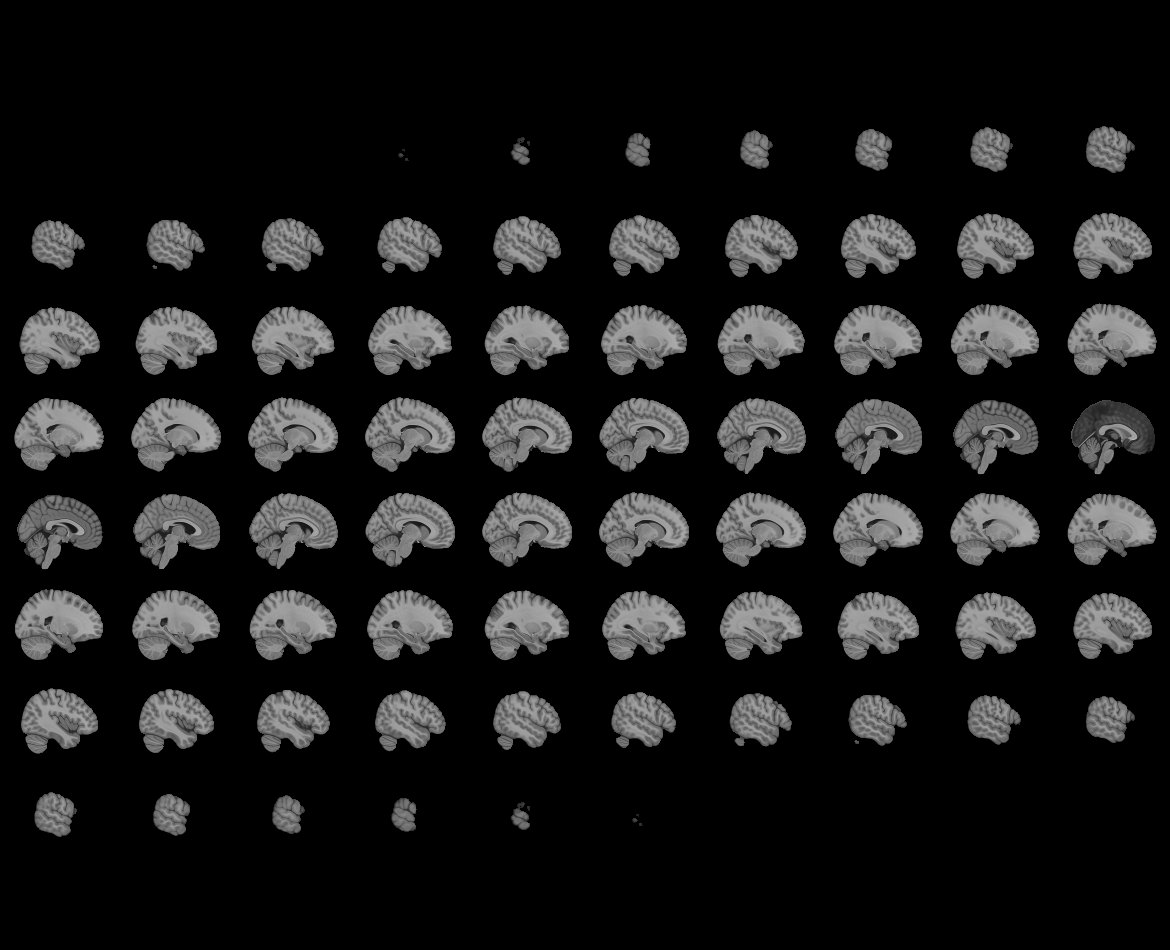
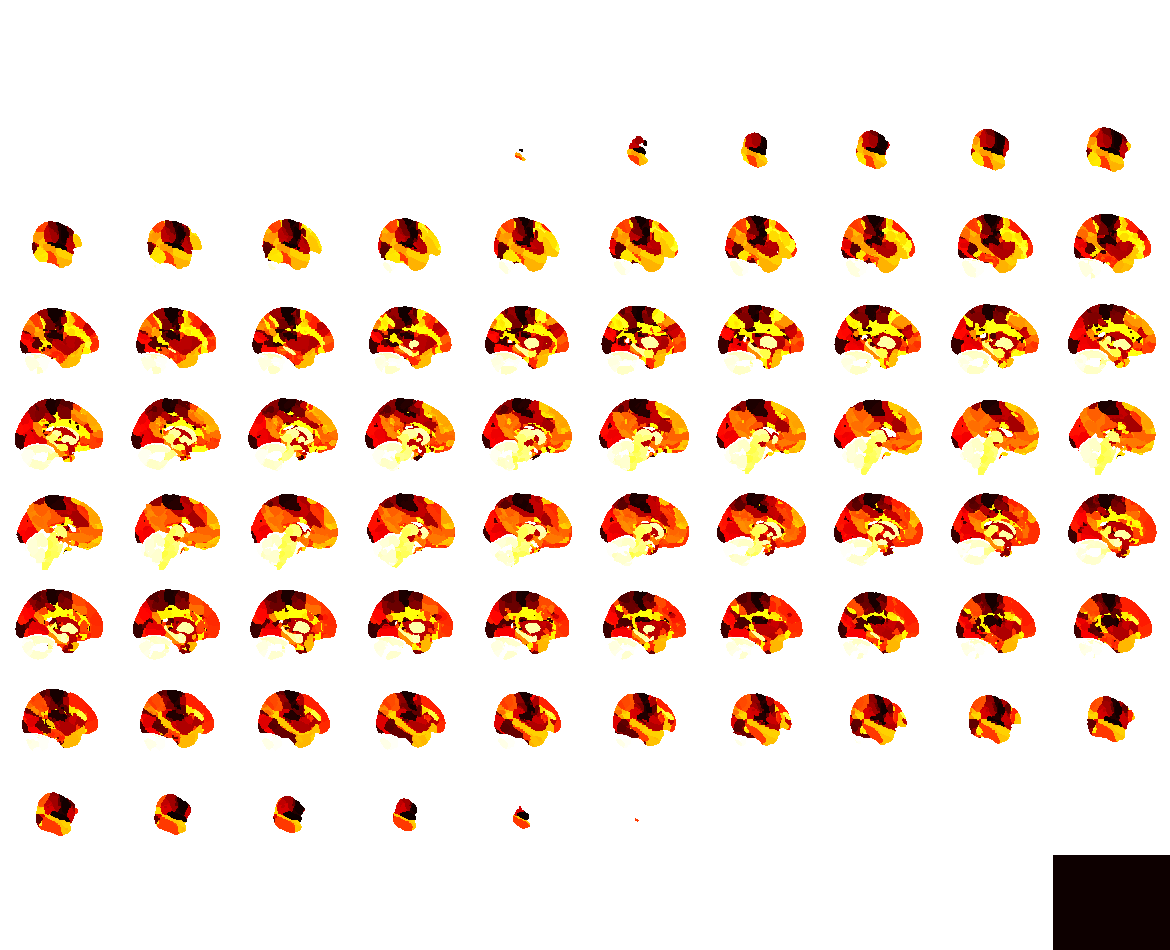

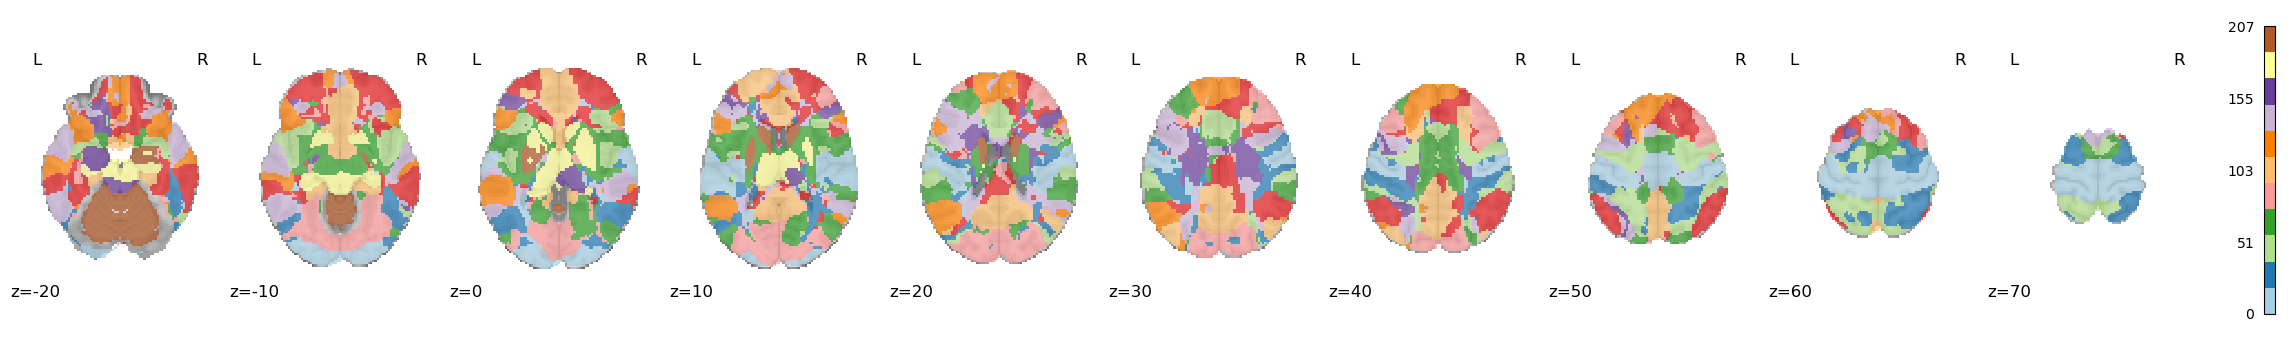

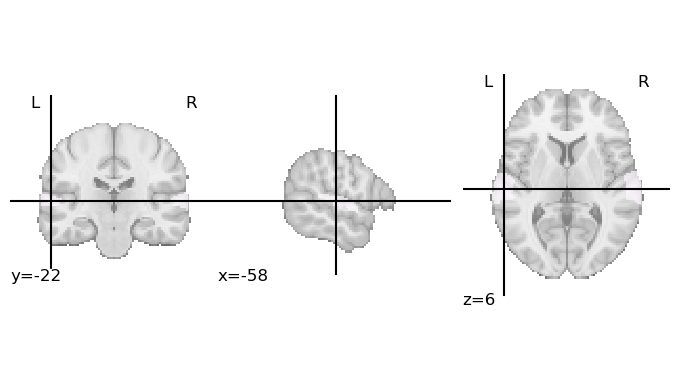

In [42]:
fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"
mask, atlas, region_labels = create_mask(fine_ICP)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)
nplot.view_img(atlas)

### Parcellate Each Subject

In [20]:
allsubs = load(n,folder1,folder2)
alldata = parcellate_all(allsubs,mask,region_labels,save=True,verbose=True, location="icp_parcellated_subs")   

NameError: name 'allsubs' is not defined

In [17]:
np.array(alldata).shape

/scratch/zaisou/51014843.dccn-l029.dccn.nl/ipykernel_61088/2957516162.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(alldata).shape


(400,)

### Load Already Parcellated Subjects and or Simulate Some Data

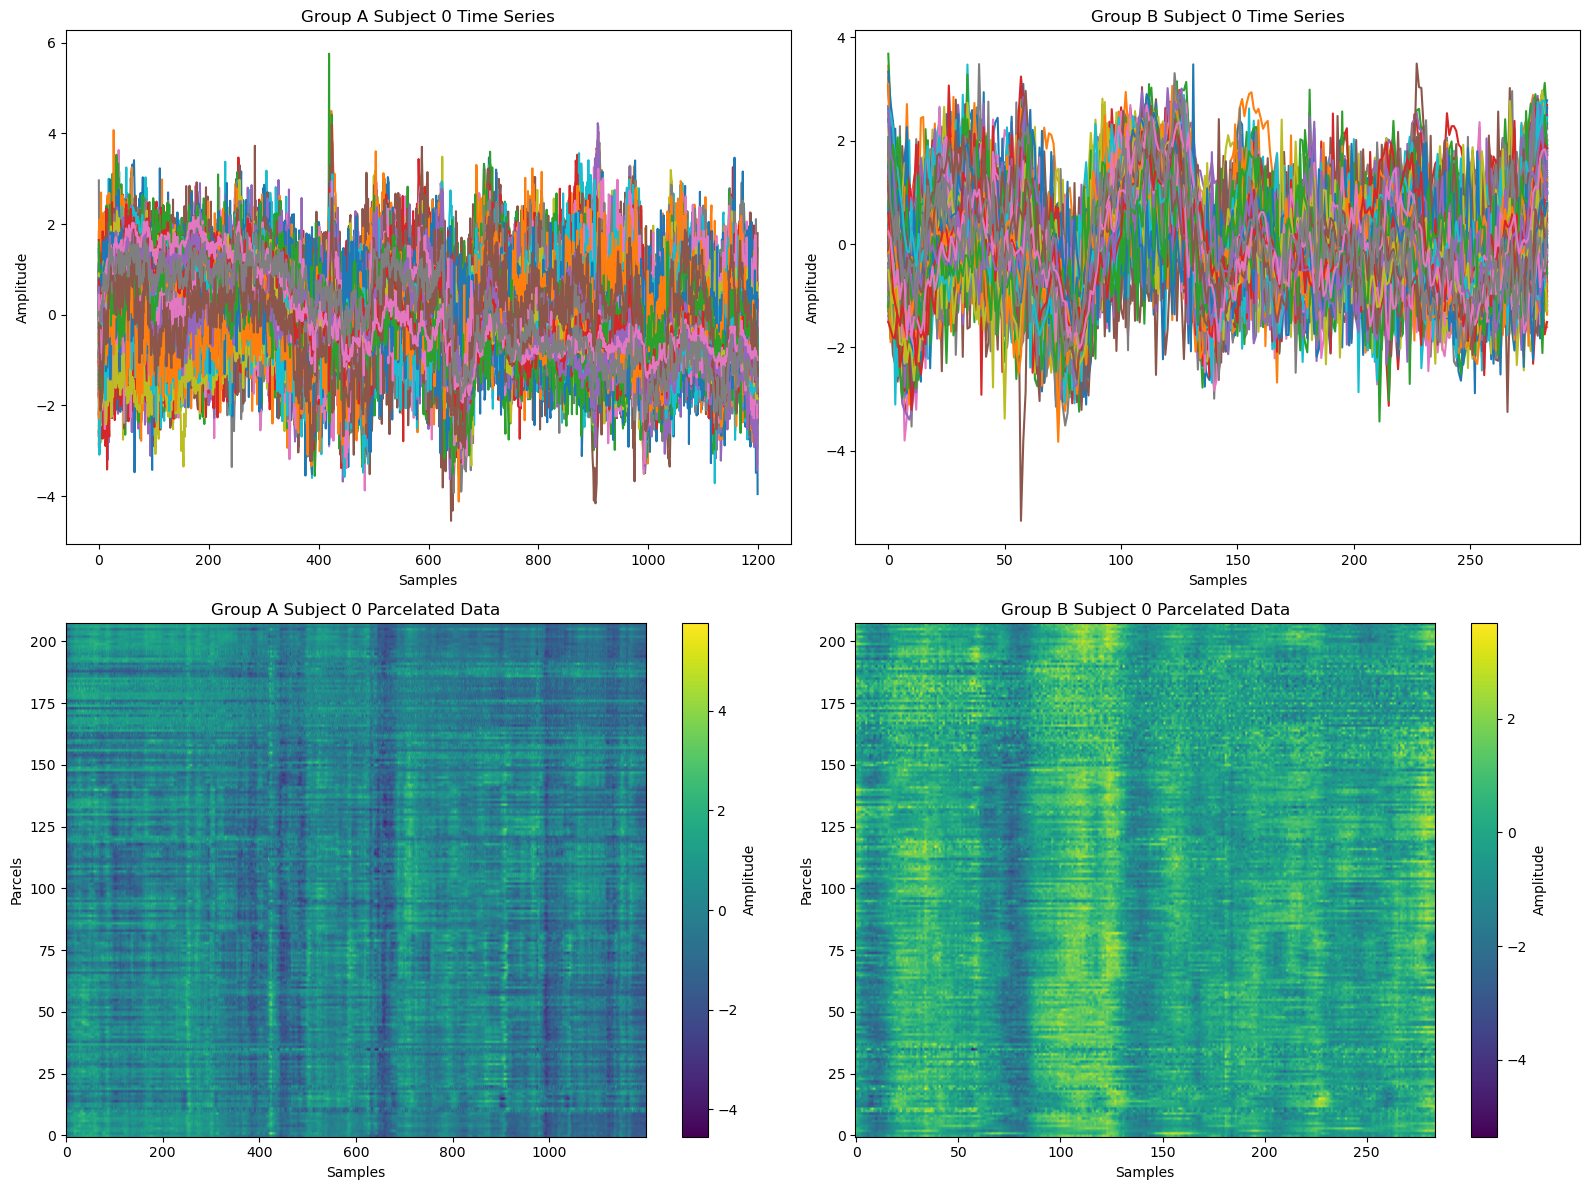

In [65]:
subjects_path = r'/project/3022057.01/icp_parcellated_subs'

groupA_data = []
groupB_data = []
groupA_type = "REST2"
groupB_type = "MOTOR"
simulate = False

if simulate:
    allsubs_data = []
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    allsubs_data.append(sub_data)
    allsubs_data = np.array(allsubs_data)
    groupA_data, groupB_data, groupA_parcels, groupB_parcels = simulate_data(allsubs_data, sig_freqA=.05,sig_freqB=.027, spatial_ratio=.01, sub_ratio=.5, original_level=.1, simulateA=True, simulateB=True)
else:
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    groupA_data.append(sub_data)
            elif (groupB_type in file):
                groupB_data.append(np.load(os.path.join(subdir,file)))

groupA_data = np.array(groupA_data)
groupB_data = np.array(groupB_data)
# # all_subjects_data = np.array(all_subjects_data)
# last = groupA_data[0].shape
# for sub in groupA_data:
#     if last != sub.shape:
#         print(sub.shape)
#     else:
#         last = sub.shape
# last = groupB_data[0].shape
# for sub in groupB_data:
#     if last != sub.shape:
#         print(sub.shape)
#     else:
#         last = sub.shape
visualize_semi_simulated_subject(groupA_data, groupB_data)

### Standardize & Demean Each ROI Time Series for Each Subject and Demean Across Parcels for Each Timepoint

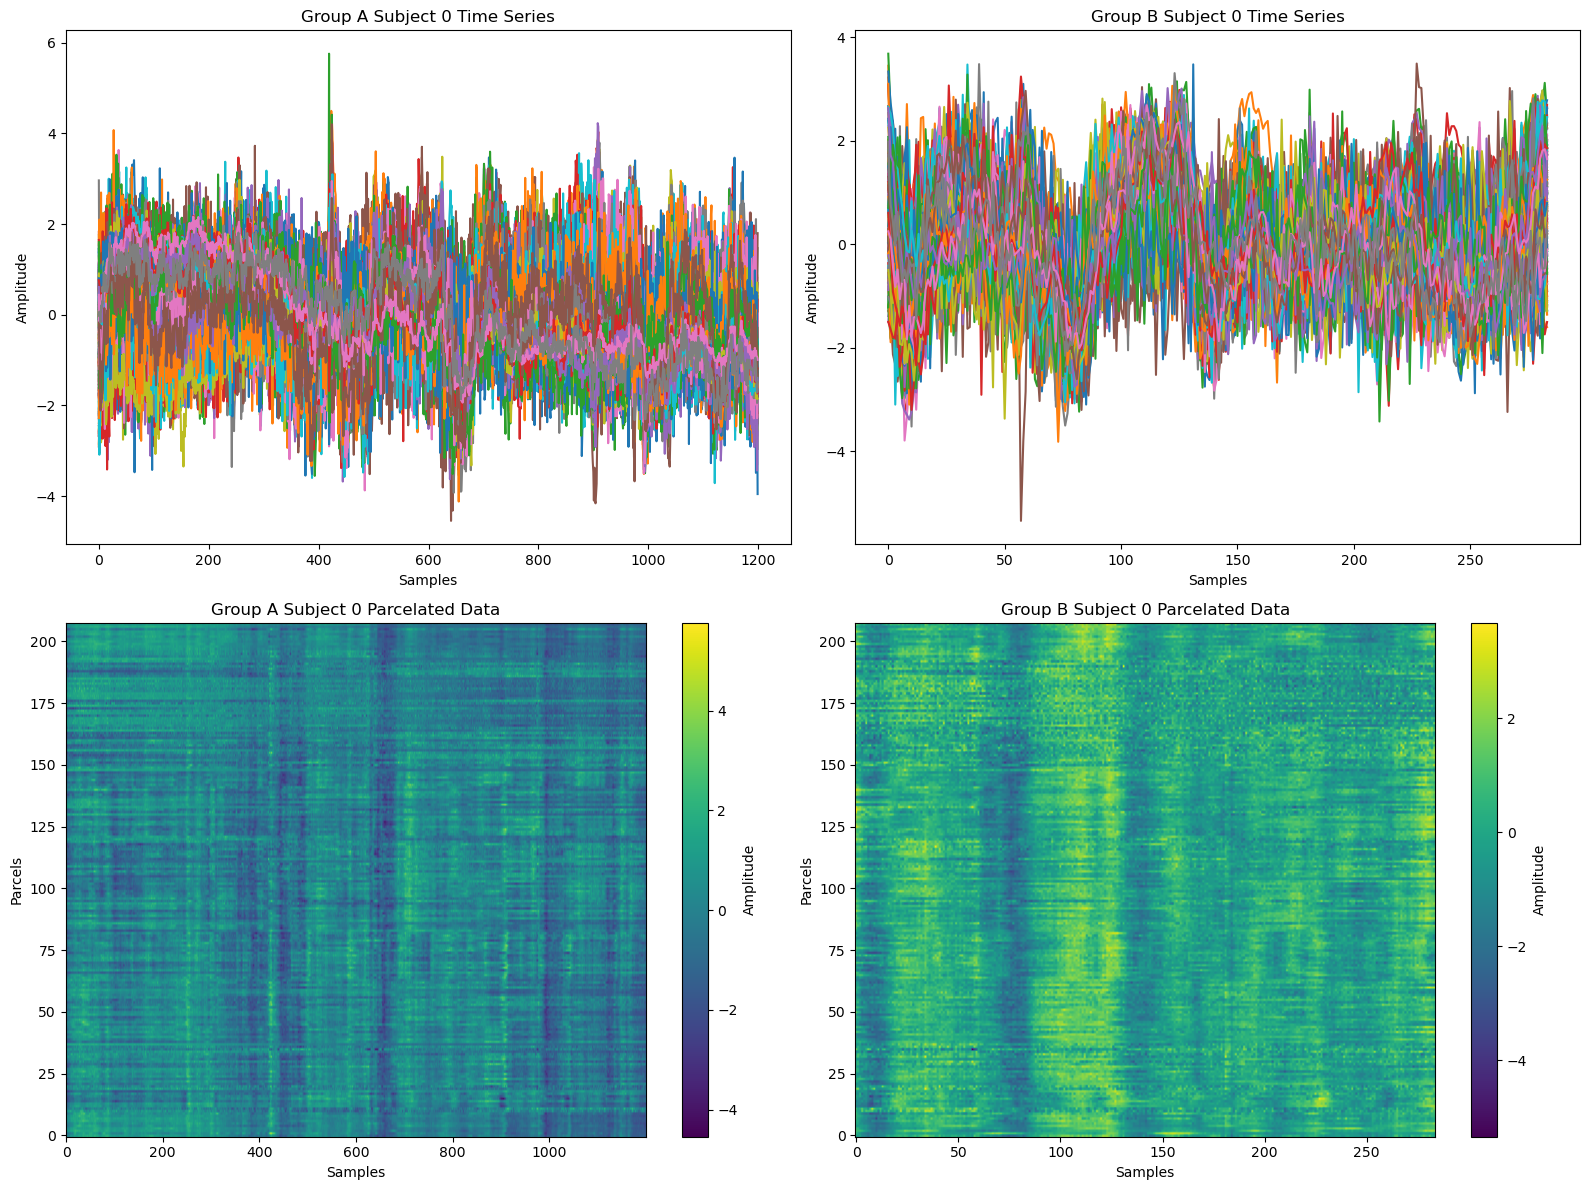

In [66]:
preprocessed_GroupA = standardize_demean(groupA_data)
preprocessed_GroupB = standardize_demean(groupB_data)
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Create Covariance Matrices

In [67]:
groupA_covs = []
for subject in preprocessed_GroupA:
    lw = LedoitWolf()
    lw.fit(subject)
    groupA_covs.append(lw.covariance_)
groupA_covs = np.array(groupA_covs)

groupB_covs = []
for subject in preprocessed_GroupB:
    lw = LedoitWolf()
    lw.fit(subject)
    groupB_covs.append(lw.covariance_)
groupB_covs = np.array(groupB_covs)

### Mean Swelling of Covariance Matrices

In [68]:
mean_swelling(groupA_covs, groupB_covs)

### Discriminant Methods

In [69]:
reshaped_preprocessed_subjects = np.array(np.vstack((preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2]), preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2]))))

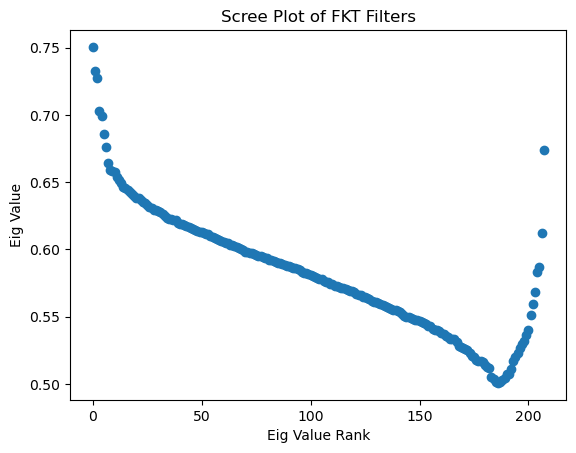

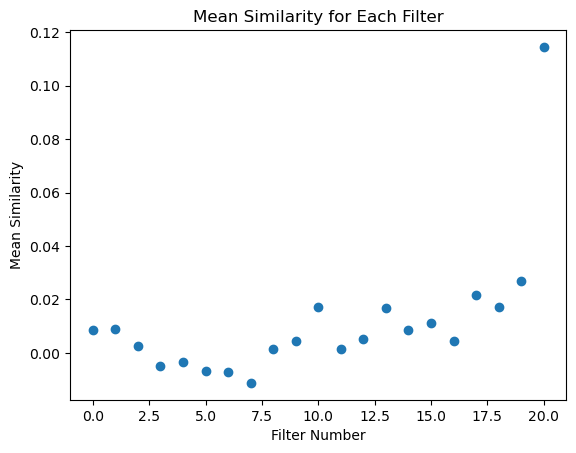

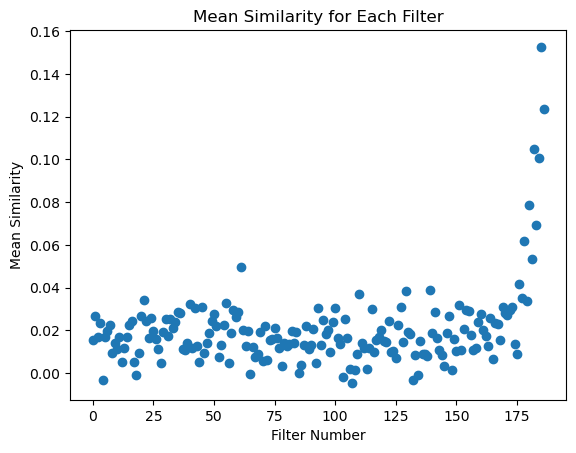

In [70]:
# Regularized CSP
fkt_eigs, fkt_filters, groupA_fktfilters, groupB_fktfilters = FKT(groupA_covs, groupB_covs, preprocessed_GroupA, preprocessed_GroupB, mean="riemann", auto_select=True, num_iterations=1000, std_multiplier=3, threshold=.5, visualize=True, gamma=0.0, d=0)
# Tangent CSP
    # Tangent space spatial filters for interpretable and efficient Riemannian classification (https://arxiv.org/pdf/1909.10567.pdf)
# TSSF_filters, TSSF_weights = TSSF(groupA_covs, groupB_covs, preprocessed_GroupA, preprocessed_GroupB, k=2, visualize=True)

# Riemannian Geometric Discriminant Dimensionality Reduction
    # Dimensionality Reduction on SPD Manifolds: The Emergence of Geometry-Aware Methods (https://ieeexplore-ieee-org.proxy.lib.umich.edu/abstract/document/7822908)

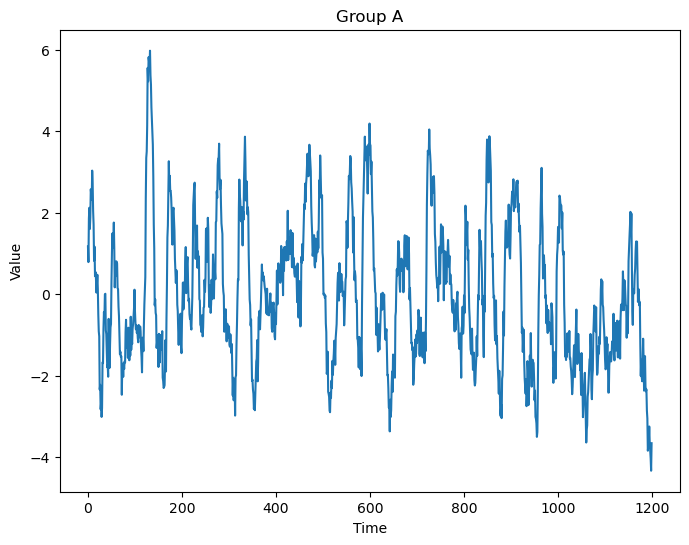

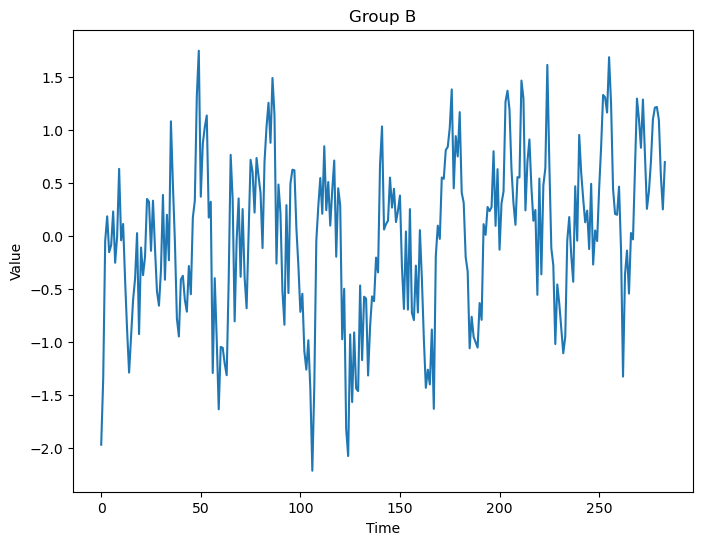

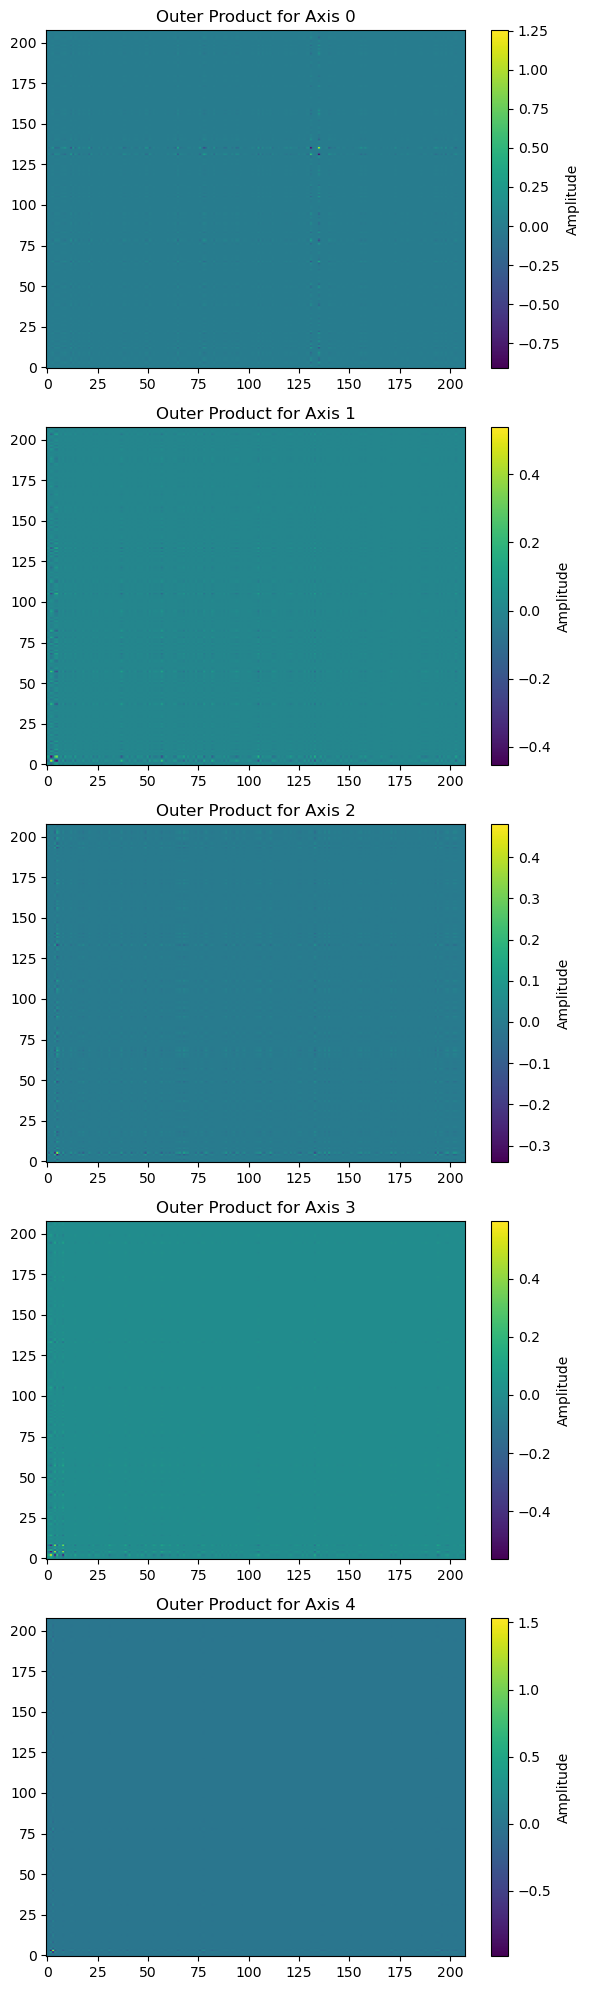

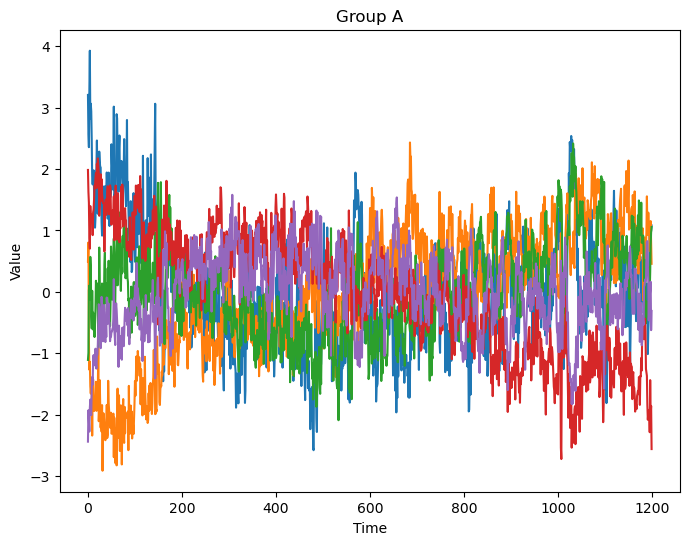

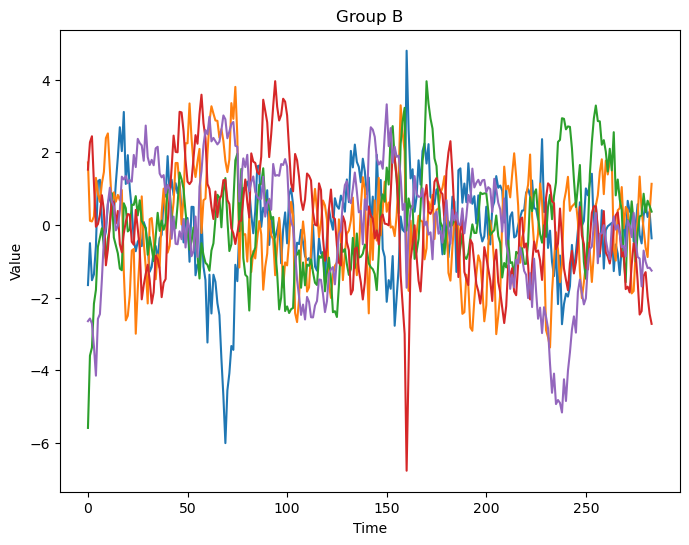

In [73]:
visualize(groupA_fktfilters,preprocessed_GroupA,preprocessed_GroupB,)
visualize(groupB_fktfilters,preprocessed_GroupA,preprocessed_GroupB)
# visualize(TSSF_filters,preprocessed_GroupA,preprocessed_GroupB, k=4)

#### Discrimination and Variance Explained by Filters

Number of FKT Filters/Eigenvectors: 1
F Ratio of FKT Variance/Total Variance: 0.002049717160582637
F Ratio of PCA Variance/Total Variance: 0.059279708270971364
F Ratio of FKT Variance/PCA Variance: 0.034577045339245736


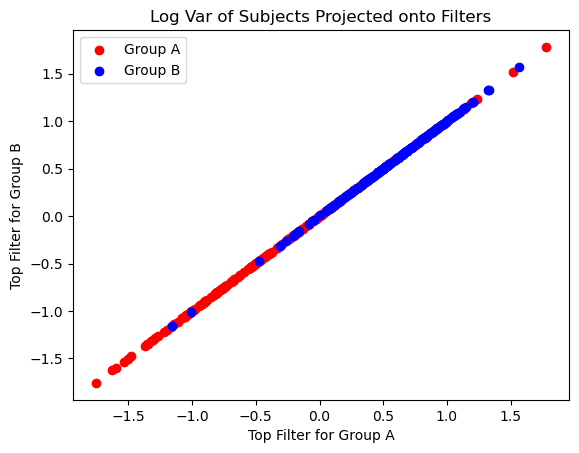

In [79]:
_, _ = f_test(fkt_filters[:,0:2],reshaped_preprocessed_subjects,preprocessed_GroupA,preprocessed_GroupB)

Number of FKT Filters/Eigenvectors: 4
F Ratio of FKT Variance/Total Variance: 0.040097357551368645
F Ratio of PCA Variance/Total Variance: 0.16563198219953856
F Ratio of FKT Variance/PCA Variance: 0.24208704755500024


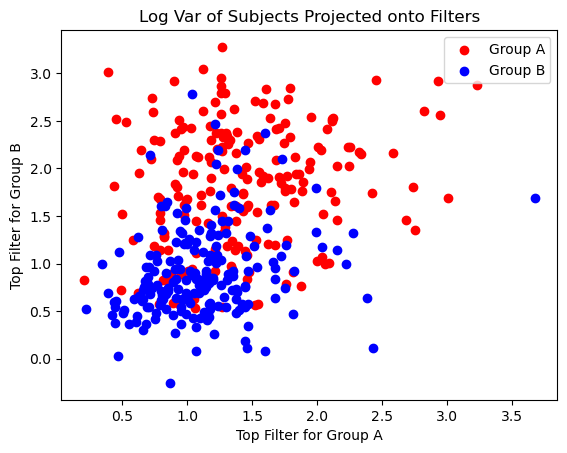

In [37]:
_, _ = f_test(TSSF_filters[:,:4],reshaped_preprocessed_subjects,preprocessed_GroupA,preprocessed_GroupB)

#### Computational Efficiency

### ICA

#### Single Subject IFA

In [35]:
def IFA(data, fkt_filters, visualize,n):
    data_projected, data_fkt_U, _, _ = FKT_proj(data,fkt_filters)
    ica = FastICA(n_components=n)
    IFA_components = ica.fit_transform(data_projected.T)
    IFA_mixing = data_fkt_U@ica.mixing_

    if visualize:
        plt.figure(figsize=(10, 6))
        num_rows = 2  # Number of rows in the subplot (image + histogram)
        for i in range(fkt_filters.shape[1]):
            # Plot the image
            plt.subplot(num_rows, fkt_filters.shape[1], i + 1)
            plt.imshow(fkt_filters[:, i:i + 1].T, aspect='auto', cmap='viridis', origin='lower')
            plt.colorbar(label='Amplitude')
            plt.title("Spatial Filters From FKT (Row {})".format(i + 1))

            # Plot the histogram
            plt.subplot(num_rows, fkt_filters.shape[1], fkt_filters.shape[1] + i + 1)
            plt.hist(fkt_filters[:, i], bins=20, color='blue', alpha=0.7)
            plt.title("Histogram of Filter {}".format(i + 1))

        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.imshow(ica.mixing_,aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title("Mixing Matrix from ICA on FKT Projected")
        plt.show()
        
        plt.figure(figsize=(10, 6))
        num_rows = 2  # Number of rows in the subplot (image + histogram)
        for i in range(IFA_components.shape[1]):
            # Plot the image
            plt.subplot(num_rows, IFA_components.shape[1], i + 1)
            plt.imshow(IFA_components[:, i:i + 1].T, aspect='auto', cmap='viridis', origin='lower')
            plt.colorbar(label='Amplitude')
            plt.title("Independent Component from ICA on FKT Projected (Row {})".format(i + 1))

            # Plot the histogram
            plt.subplot(num_rows, IFA_components.shape[1], IFA_components.shape[1] + i + 1)
            plt.hist(IFA_components[:, i], bins=20, color='blue', alpha=0.7)
            plt.title("Histogram of Independent Filter {}".format(i + 1))
        plt.tight_layout()
        plt.show()
        
        # Create a figure and axes for subplots
        fig, axes = plt.subplots(IFA_components.shape[1], 1, figsize=(6, 4*IFA_components.shape[1]))
        for i in range(IFA_components.shape[1]):
            if IFA_components.shape[1] == 1:
                ax = axes
            else:
                ax = axes[i]
            ax.plot(IFA_mixing[:,i],label=f"IFA Mixing Vector for Component {i}")
            ax.legend()
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        plt.tight_layout()
        plt.show()
        
    return IFA_components, IFA_mixing, ica.mixing_


#### Applied to a Subject from Group A

/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:595: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(


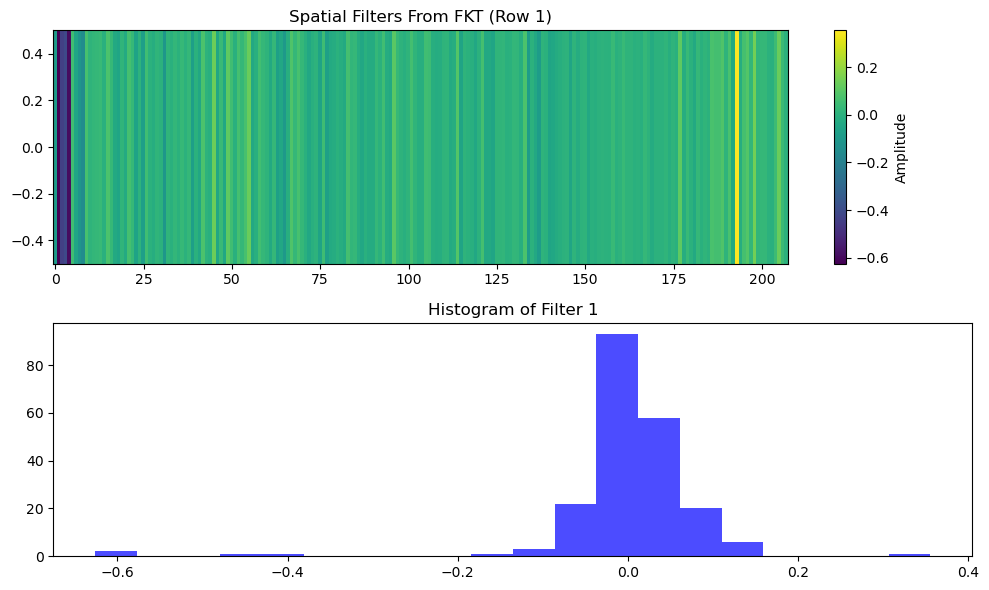

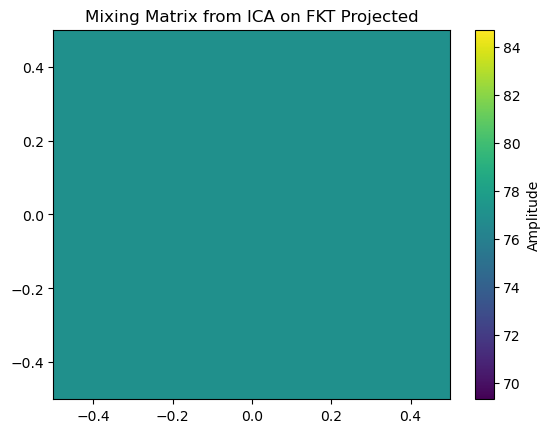

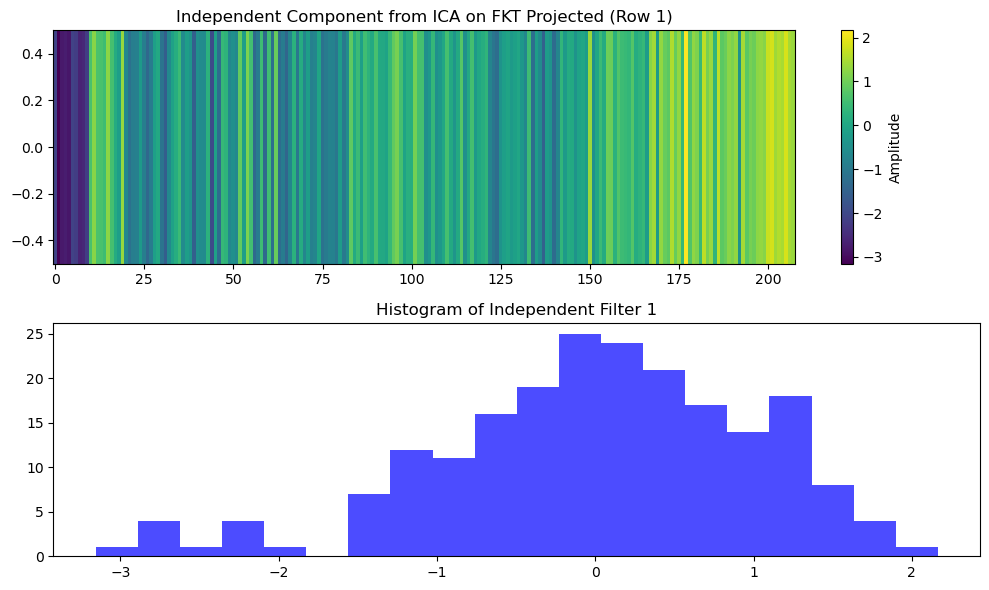

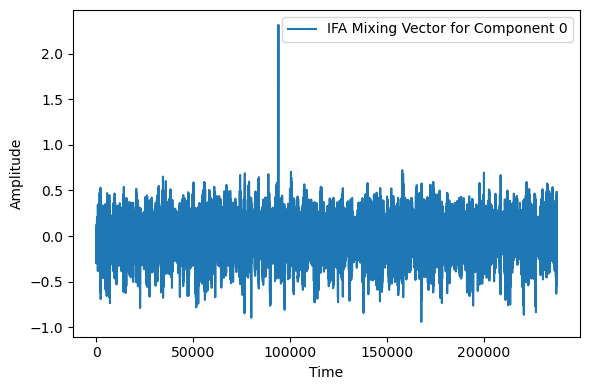

<Figure size 640x480 with 0 Axes>

In [74]:
groupA_subject = preprocessed_GroupA[np.random.choice(range(preprocessed_GroupA.shape[0])),:,:]
groupA_IFAcomponents, _, _ = IFA(np.reshape(preprocessed_GroupA,(-1,208)), groupA_fktfilters,visualize=True,n=4)


#### Applied to a Subject from Group B

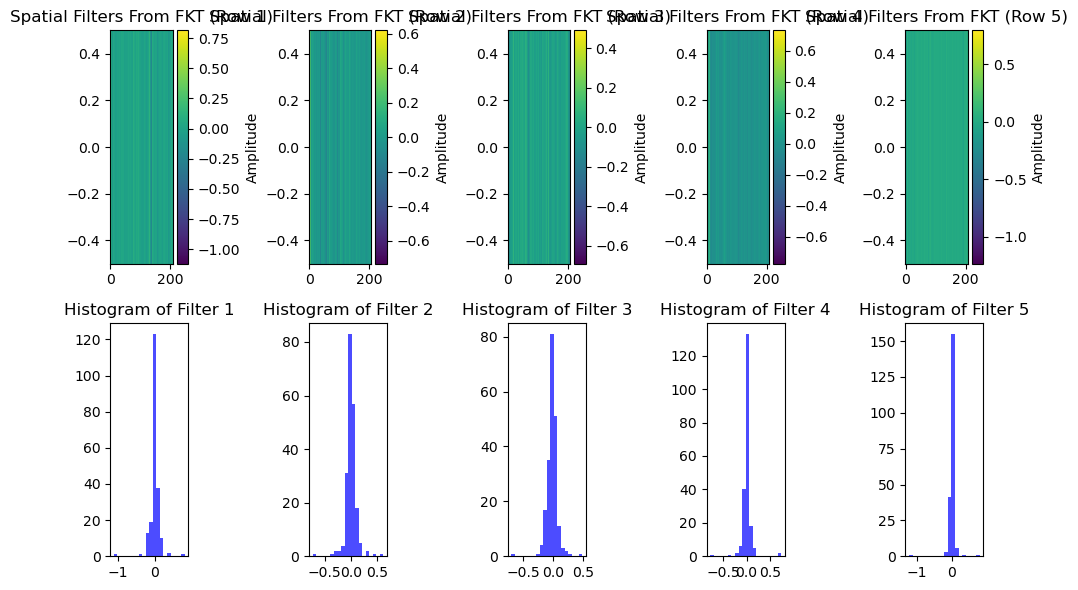

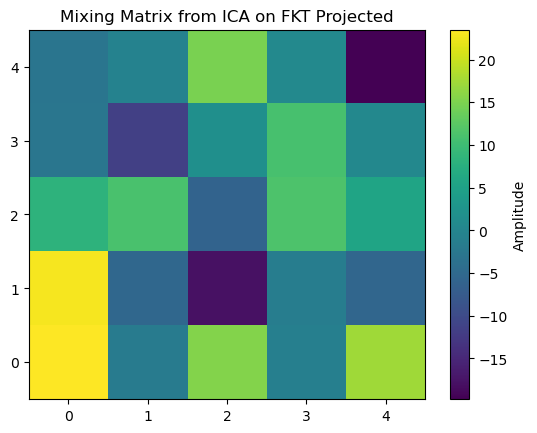

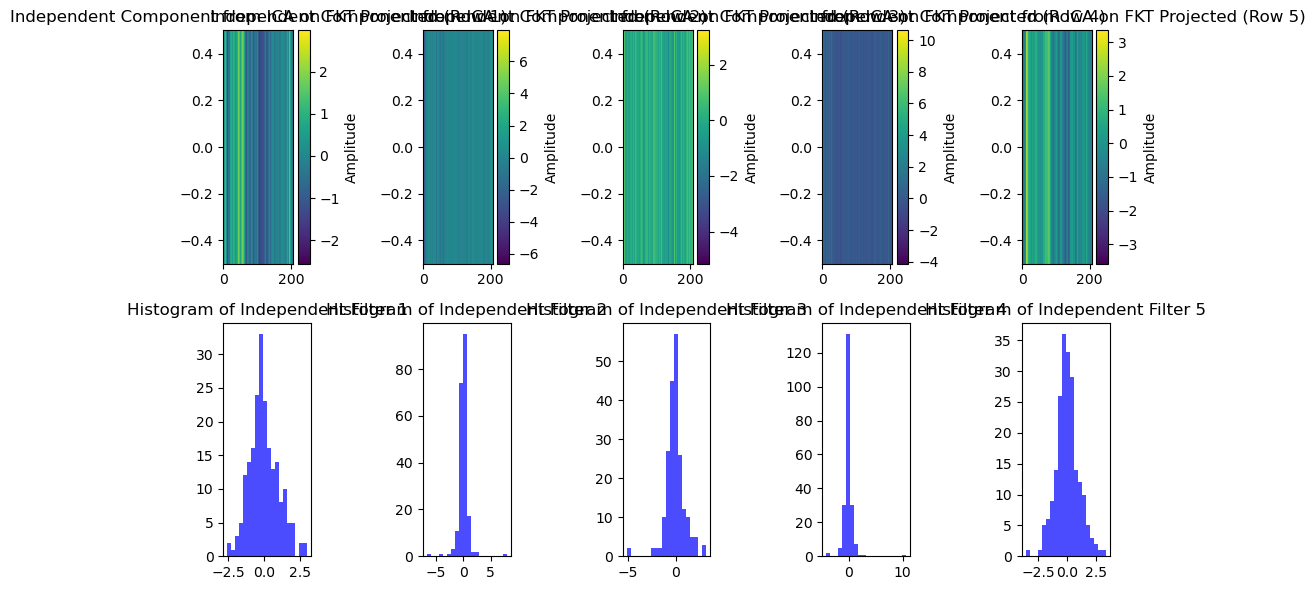

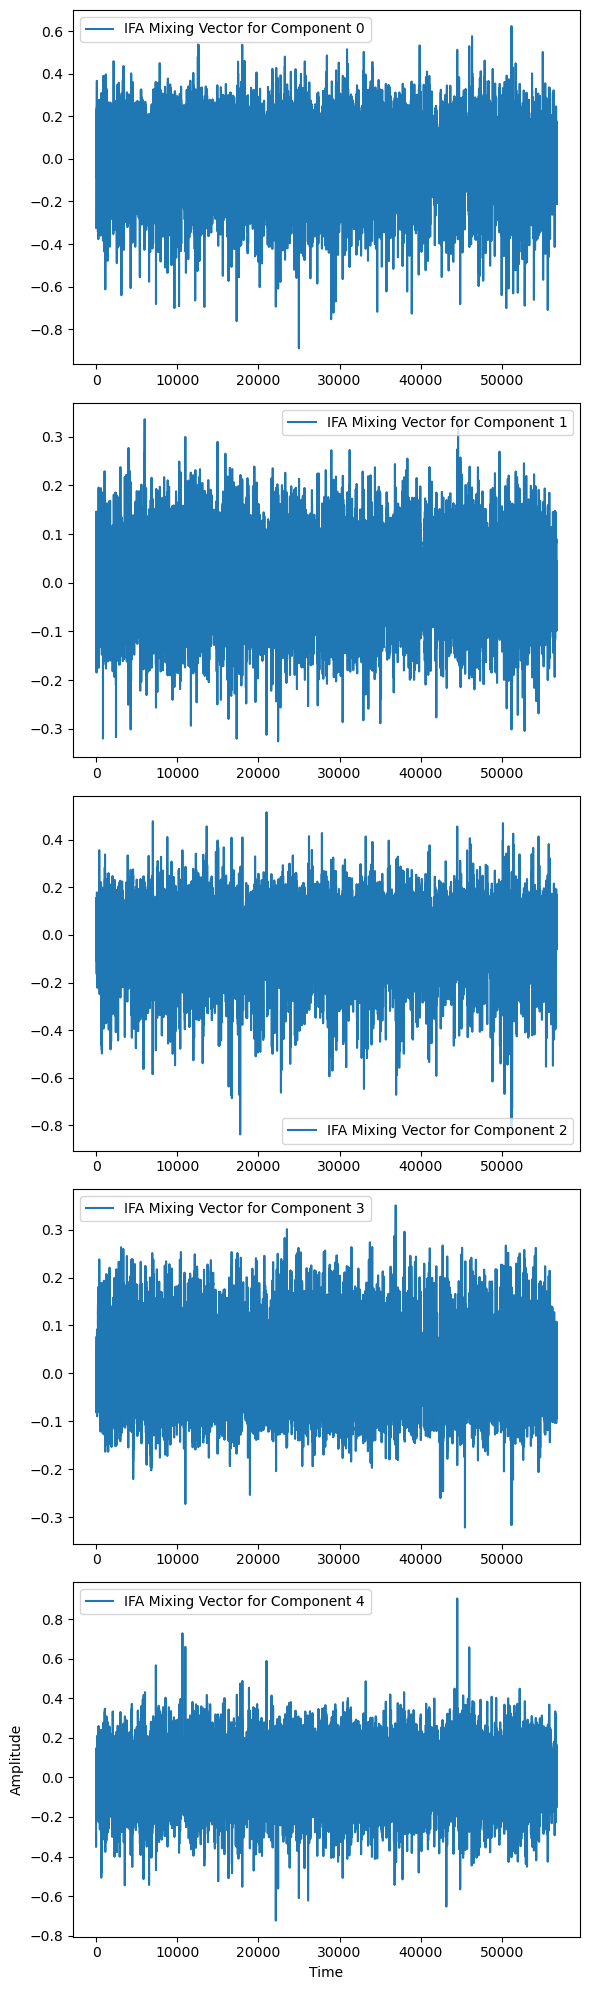

<Figure size 640x480 with 0 Axes>

In [75]:
groupB_subject = preprocessed_GroupB[np.random.choice(range(preprocessed_GroupB.shape[0])),:,:]
groupB_IFAcomponents, _, _ = IFA(np.reshape(preprocessed_GroupB,(-1,208)), groupB_fktfilters,visualize=True,n=5)

#### Group IFA

/opt/anaconda3/2023.03/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


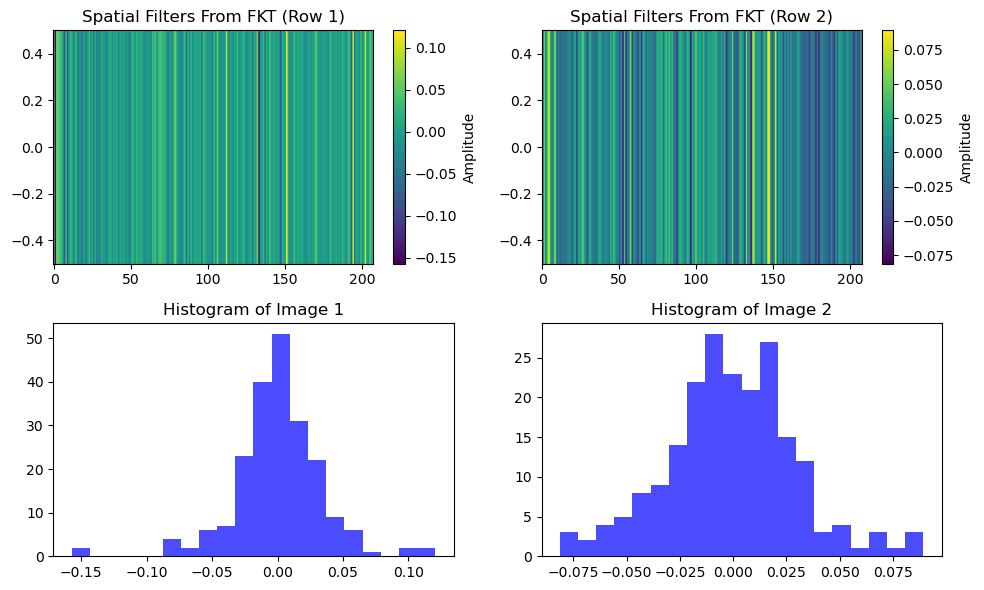

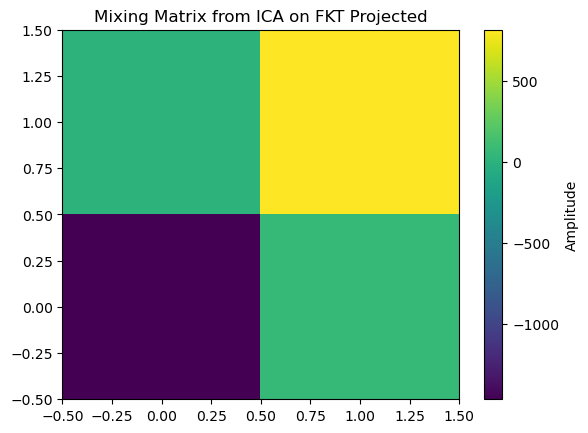

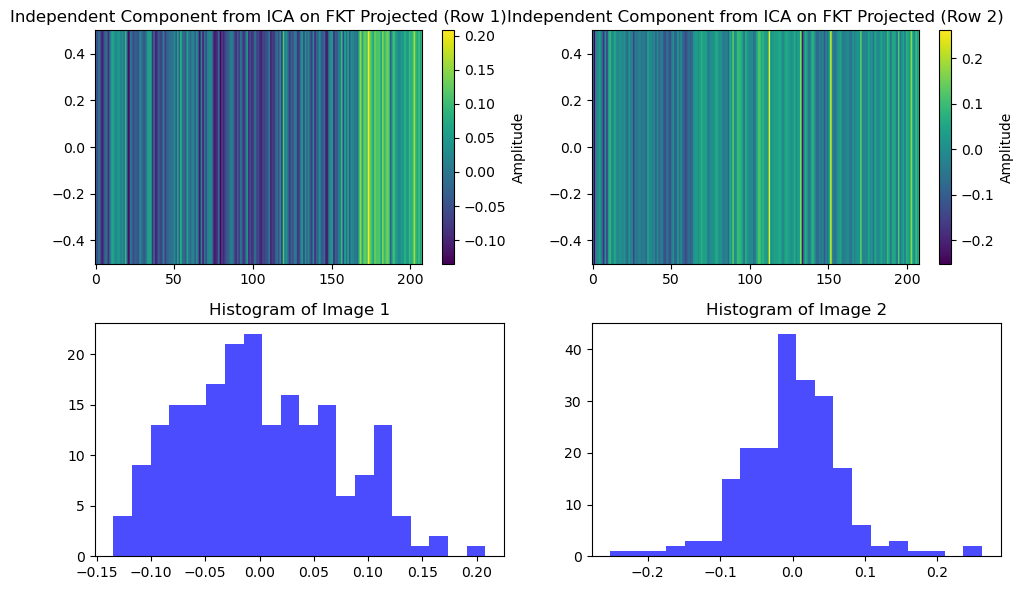

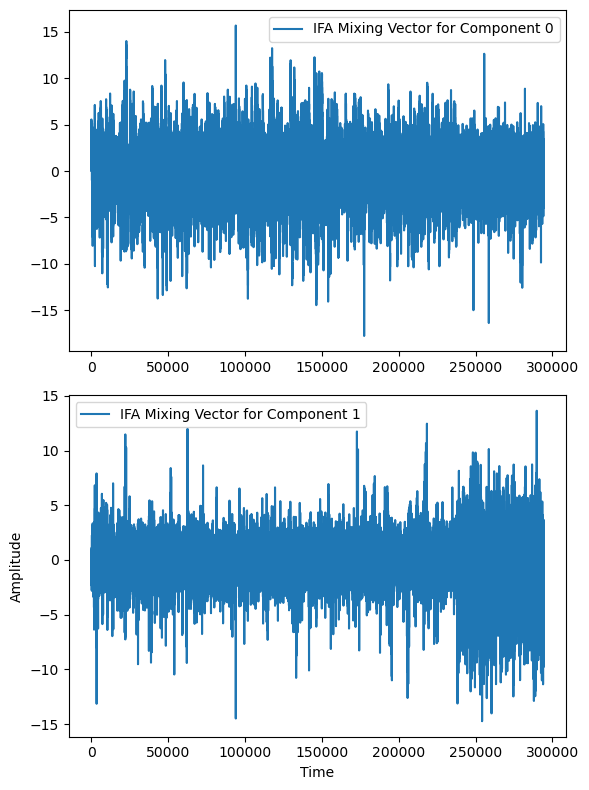

<Figure size 640x480 with 0 Axes>

In [30]:
groupIFA_components, _, _ = IFA(reshaped_preprocessed_subjects, fkt_filters, visualize=True)

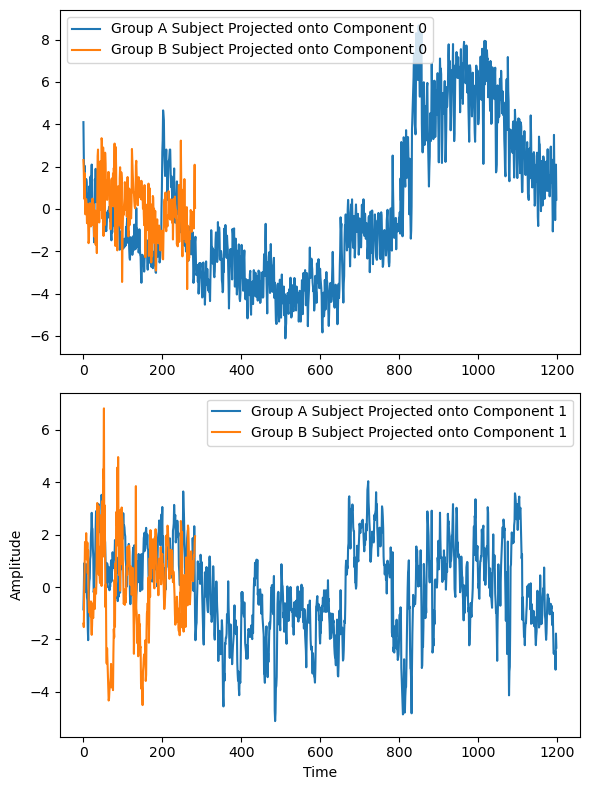

In [43]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(groupIFA_components.shape[1], 1, figsize=(6, 4*groupIFA_components.shape[1]))

for i in range(groupIFA_components.shape[1]):
    if groupIFA_components.shape[1] == 1:
        ax = axes
    else:
        ax = axes[i]
    group_comp = groupIFA_components[:,i]
    std_fkt_ica = (group_comp-np.mean(group_comp,keepdims=True,axis=0))/np.std(group_comp,axis=0)
    masked_comp = group_comp*(np.abs(std_fkt_ica)>1.0)
    ax.plot(groupA_subject@masked_comp,label=f"Group A Subject Projected onto Component {i}")
    ax.plot(groupB_subject@masked_comp,label=f"Group B Subject Projected onto Component {i}")
    ax.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

#### Comparison to Group ICA

/opt/anaconda3/2023.03/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


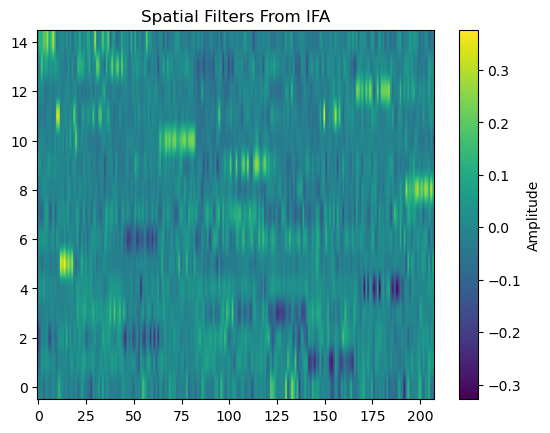

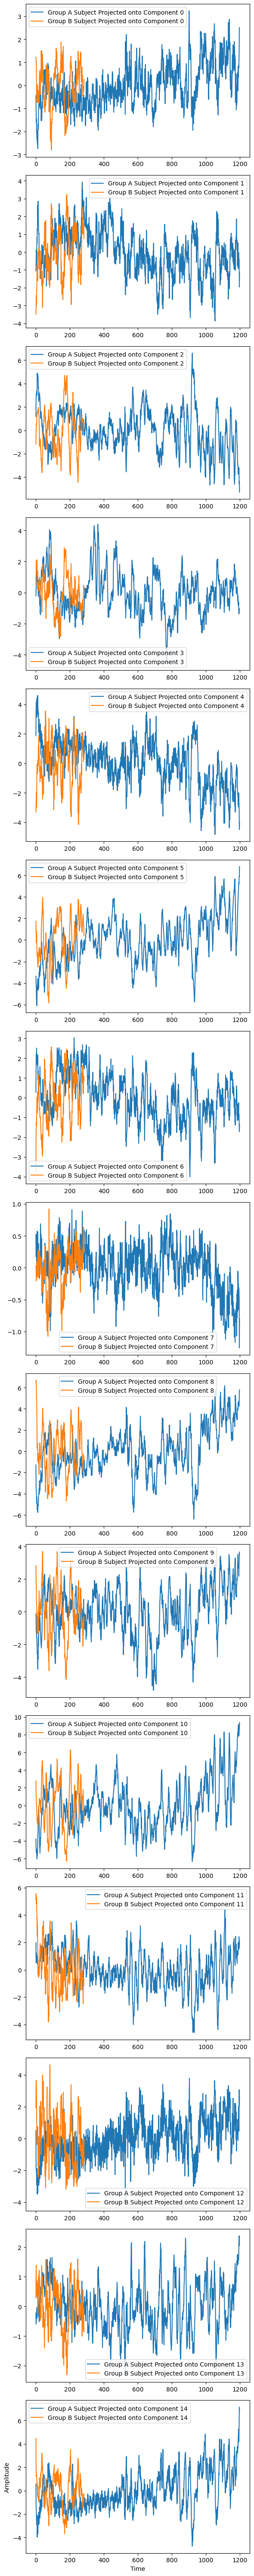

In [31]:
n = 15
ica = FastICA(n_components=n)
group_components = ica.fit_transform(reshaped_preprocessed_subjects.T)
group_mixing = ica.mixing_

plt.figure()
plt.imshow(group_components.T,aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.title("Spatial Filters From IFA")
plt.show()

# Create a figure and axes for subplots
fig, axes = plt.subplots(group_components.shape[1], 1, figsize=(6, 4*group_components.shape[1]))

for i in range(group_components.shape[1]):
    if group_components.shape[1] == 1:
        ax = axes
    else:
        ax = axes[i]
    group_comp = group_components[:,i]
    std_fkt_ica = (group_comp-np.mean(group_comp,keepdims=True,axis=0))/np.std(group_comp,axis=0)
    masked_comp = group_comp*(np.abs(std_fkt_ica)>2.0)
    ax.plot(groupA_subject@masked_comp,label=f"Group A Subject Projected onto Component {i}")
    ax.plot(groupB_subject@masked_comp,label=f"Group B Subject Projected onto Component {i}")
    ax.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

### Visualize in Brain

/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



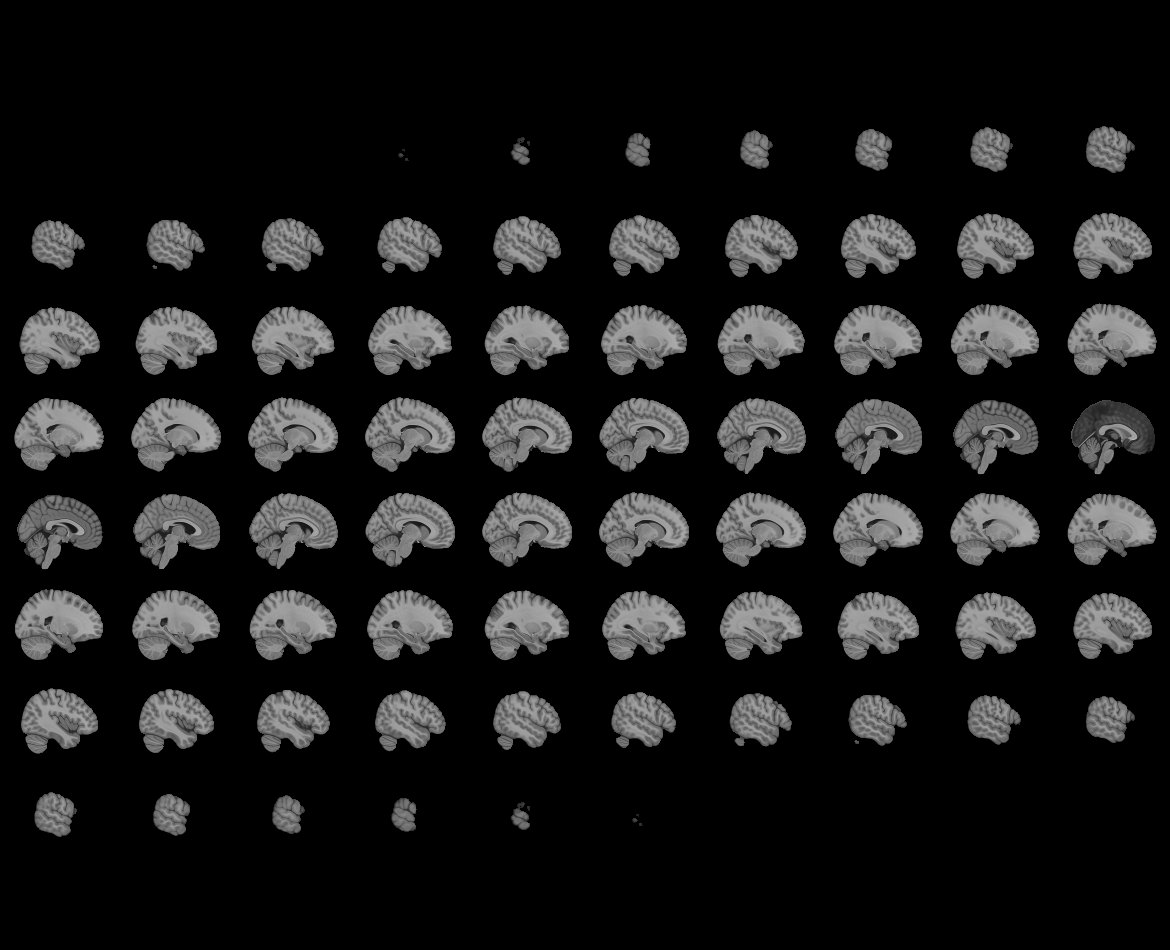
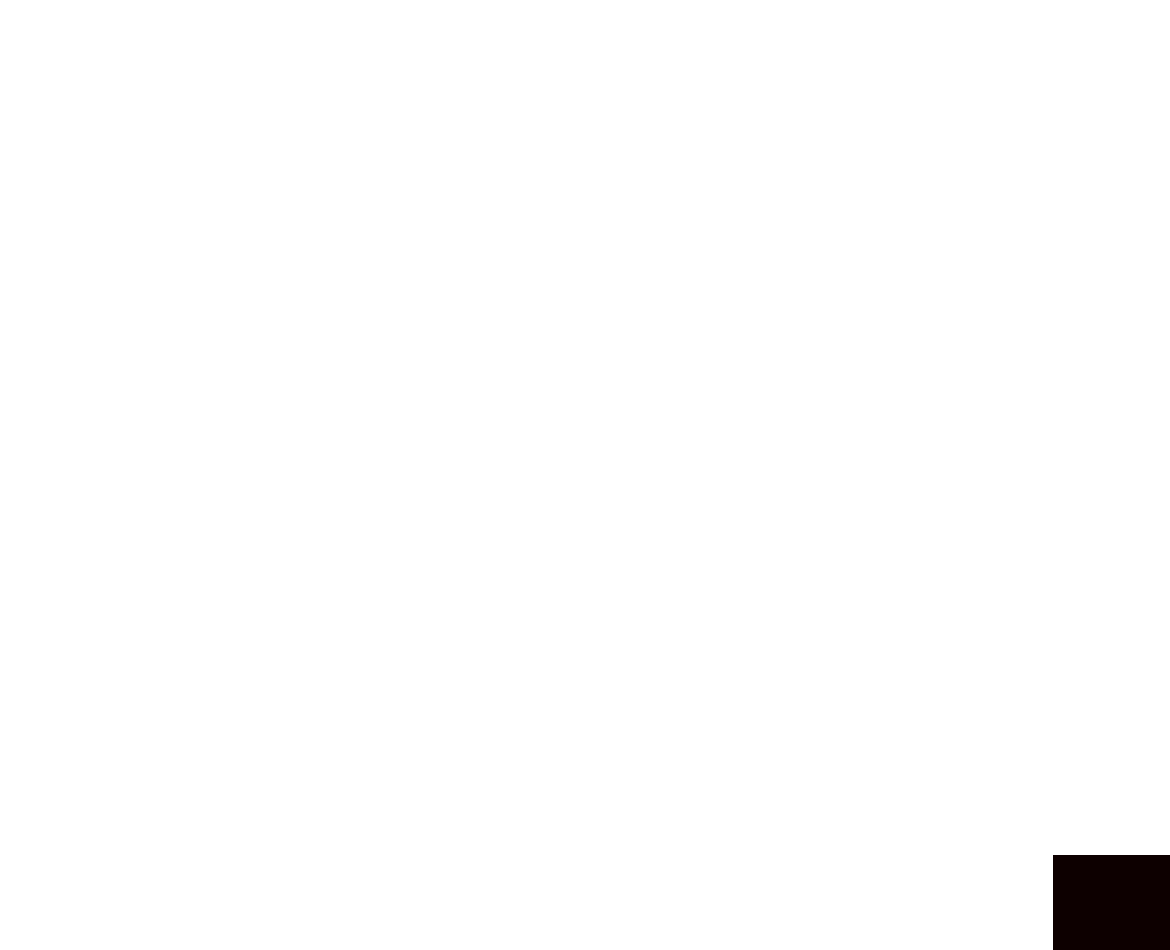

In [85]:
regions = []
brain_strings = []
masked_comps = []
for i in range(groupA_IFAcomponents.shape[1]):
    groupIFA_comp = groupA_IFAcomponents[:,i]
    std_groupIFA = (groupIFA_comp-np.mean(groupIFA_comp,keepdims=True,axis=0))/np.std(groupIFA_comp,axis=0)
    masked_comp = std_groupIFA*(np.abs(std_groupIFA)>3)
    masked_comps.append(masked_comp)
    array = np.where(np.abs(std_groupIFA)>3)[0]+1
    regions.append(array)
    stringified_array = ' | '.join([f'(a == {num})' for num in array])
    final_string = f"(({stringified_array}))"
    brain_strings.append(final_string)
masked_comps = np.array(masked_comps).T

nplot.view_img(nimg.math_img(brain_strings[0], a=atlas))

In [64]:
print(np.where(np.abs(masked_comps[:,0])>0))
print(groupB_parcels)

(array([30, 52]),)
[30 52]


### Unsupervised IFA

In [52]:
average = np.mean(np.vstack((groupA_covs,groupB_covs)),axis=0)
covs = []
for sub in preprocessed_GroupA:
    covs.append(regcov(sub, gamma=0.00000, sc=1.0, beta=.9, ddof=1.0, groundtruth=average))

for sub in preprocessed_GroupB:
    covs.append(regcov(sub, gamma=0.00000, sc=1.0, beta=.9, ddof=1.0, groundtruth=average))

covs = np.array(covs)

n_matrices = covs.shape[0]
all = np.zeros((n_matrices, n_matrices))
for i in range(n_matrices):
    for j in range(i, n_matrices):
        Cs = covs[j]
        oh = covs[i]

        eigs, _ = FKT(Cs, oh,preprocessed_GroupA, auto_select=True, threshold=.8, visualize=False, gamma=0.00, l2=0.01,l3=0.4)
        print(i,j, eigs)
        all[i, j] = np.sum(eigs)
        all[j, i] = all[i, j]

sns.heatmap(all, cmap='RdBu_r')

0 0 []
0 1 []
0 2 []
0 3 []
0 4 []
0 5 []
0 6 []
0 7 []
0 8 []
0 9 []
0 10 []
0 11 []
0 12 []
0 13 []
0 14 []
0 15 []
0 16 []
0 17 []
0 18 []
0 19 []
0 20 []
0 21 []
0 22 []
0 23 []
0 24 []
0 25 []
0 26 []
0 27 []
0 28 []
0 29 []
0 30 []
0 31 []
0 32 []
0 33 []
0 34 []
0 35 []
0 36 []
0 37 []
0 38 []
0 39 []
0 40 []
0 41 []
0 42 []
0 43 []
0 44 []
0 45 []
0 46 []
0 47 []
0 48 []
0 49 []
0 50 []
0 51 []
0 52 []
0 53 []
0 54 []
0 55 []
0 56 []
0 57 []
0 58 []
0 59 []
0 60 []
0 61 []
0 62 []
0 63 []
0 64 []
0 65 []
0 66 []
0 67 []
0 68 []
0 69 []
0 70 []
0 71 []
0 72 []
0 73 []
0 74 []
0 75 []
0 76 []
0 77 []
0 78 []
0 79 []
0 80 []
0 81 []
0 82 []
0 83 []
0 84 []
0 85 []
0 86 []
0 87 []
0 88 []
0 89 []
0 90 []
0 91 []
0 92 []
0 93 []
0 94 []
0 95 []
0 96 []
0 97 []
0 98 []
0 99 []
0 100 []
0 101 []
0 102 []
0 103 []
0 104 []
0 105 []
0 106 []
0 107 []
0 108 []
0 109 []
0 110 []
0 111 []
0 112 []
0 113 []
0 114 []
0 115 []
0 116 []
0 117 []
0 118 []
0 119 []
0 120 []
0 121 []
0 122 []
0 1

KeyboardInterrupt: 

/opt/anaconda3/2023.03/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


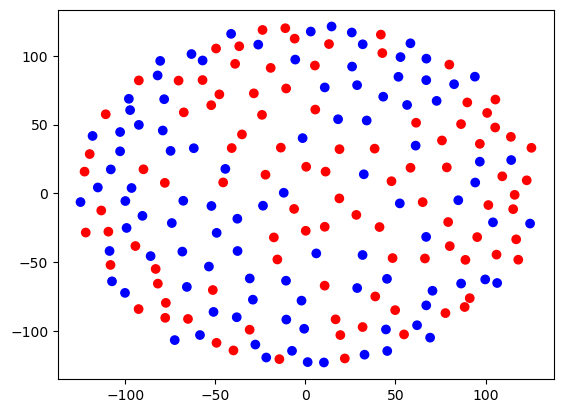

In [69]:
mds = MDS(n_components=2, dissimilarity='precomputed')
embedding = mds.fit_transform(all)

colors = ['blue' for i in range(len(embedding))]
for sub in range(preprocessed_GroupA.shape[0]):
    colors[sub] = 'red'

# Visualize the points with labels in 3D
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=colors)

# # Customize the plot
# ax.set_title('MDS Visualization in 3D with Odd/Even Colors')
# ax.set_xlabel('MDS Dimension 1')
# ax.set_ylabel('MDS Dimension 2')
# ax.set_zlabel('MDS Dimension 3')

plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

plt.show()